<p style="font-size: 40px; font-weight: bold; text-align: center;">Household electric power consumption</p>

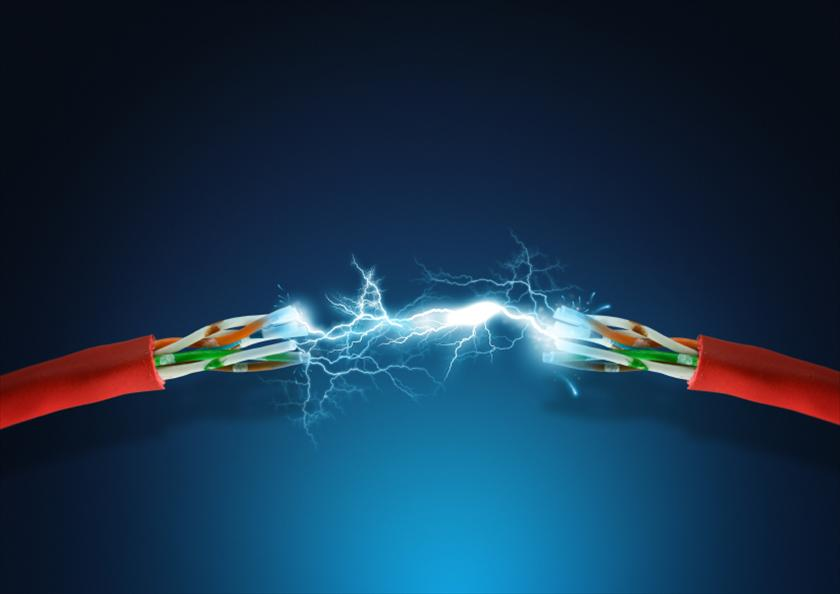

<h2>Objective</h2> 

Conduct an analysis of multivariate time series of electrical power counsumption and use LSTM to predict future average daily consumption of electricity using the past values, develop and compare different approaches to time-series problems.

<h2>Dataset Information:</h2>
    
The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years. The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute. It is a multivariate series comprised of seven variables (besides the date and time); they are:

- global active power: The total active power consumed by the household (kilowatts).
- global reactive power: The total reactive power consumed by the household (kilowatts).
- voltage: Average voltage (volts).
- global intensity: Average current intensity (amps).
- sub metering 1: Active energy for kitchen (watt-hours of active energy).
- sub metering 2: Active energy for laundry (watt-hours of active energy).
- sub metering 3: Active energy for climate control systems (watt-hours of active energy).

<h2>Role:</h2>

Worked 21 hours a week as a data scientist to perform and developed a model that could electric power consumption. I used different analysing techniques, data preprocessing and visualisation. Then, I moved to the feature engineering part where I used various techniques that included feature selection, building and testing LSTM model, tuning the model, fine  hyperparameters, with final models evaluation & reporting.


The description of data can be found here "http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption">



## Step 0. Import libraries

In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime
import math

import plotly.express as px
from scipy.stats import randint

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler  
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from feature_engine.imputation import MeanMedianImputer

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import utils
import itertools


In [2]:
# Visualizing histogram, probability plot and box-plot

def diagnostic_plots(df, variable):
    fig = plt.figure(figsize = (18, 5))
    
    # Histogram
    plt.subplot(1, 3, 1)
    fig = df[variable].hist(bins = 30)
    fig.set_ylabel ('Count')
    fig.set_xlabel(variable)
    
    # Probability plot
    plt.subplot(1, 3, 2)
    stats.probplot(x = df[variable], dist = 'norm', plot = plt)
    
    # Box-plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y = df[variable])
    plt.title('Boxplot')

    plt.show()

In [3]:
def plot_day_data(day:datetime.date) -> None:

    # Create time range and xtick for the day
    time_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='1T')
    xtick_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='D')
    
    # Filter the data for the day and fill missing values with NaN
    tmp_df = df[['Global_active_power']][df.index.isin(time_range)].copy()
    tmp_df = tmp_df.combine_first(pd.DataFrame(index=time_range, columns=tmp_df.columns))
    
    # Calculate the marker place
    marker_place = tmp_df[['Global_active_power']].max().item() / 2
    # Identify the missing values
    missing_values = tmp_df.isna().any(axis=1)
    
    # Drawing the plot
    plt.figure(figsize=(15, 5))
    plt.plot(
        tmp_df[['Global_active_power']][~missing_values],
        label = 'Normal Data'
    )
    plt.plot(
        tmp_df[['Global_active_power']][missing_values].fillna(marker_place), 
        marker='o', 
        linestyle='None',
        label = 'Missing Data',
        color = 'r'
    )
    plt.xticks(xtick_range, rotation=90)
    plt.grid(axis='y')
    plt.title('Global_active_power ({}:{})'.format(str(time_range[1].date()),str(time_range[-1].date())),fontsize=15)
    plt.ylabel('value')
    plt.legend()
    plt.show()
    
    return None

In [4]:
# Check multicollinearity
def multicollinearity(df, threshold):
    
    col_corr = set()
    
    corr_matrix = df.corr().round(3)
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])

## Step 1. Import Dataset

In [5]:
# Load dataset from directory
df = pd.read_csv('../AI/All Data Files/household_power_consumption.txt', sep = ';', parse_dates = {
    'dt': ['Date', 'Time']}, infer_datetime_format = True, low_memory = False, na_values = ['nan', '?'], index_col = 'dt')

## Step 2. Data exploration 

In [6]:
# Check the dataset first 10 rows
df.head(10)

Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
2006-12-16 17:29:00                3.520                  0.522   235.02   
2006-12-16 17:30:00                3.702                  0.520   235.09   
2006-12-16 17:31:00                3.700                  0.520   235.22   
2006-12-16 17:32:00                3.668                  0.510   233.99   
2006-12-16 17:33:00                3.662                  0.510   233.86   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
2006-12-16 17:29:00              15.0             0.0             2.0   
2006-12-16 17:30:00              15.8             0.0             1.0   
2006-12-16 17:31:00              15.8             0.0             1.0   
2006-12-16 17:32:00              15.8             0.0             1.0   
2006-12-16 17:33:00              15.8             0.0             2.0   

                     Sub_metering_3  
dt                                   
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0  
2006-12-16 17:29:00            17.0  
2006-12-16 17:30:00            17.0  
2006-12-16 17:31:00            17.0  
2006-12-16 17:32:00            17.0  
2006-12-16 17:33:00            16.0

In [7]:
# Check dataset features
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [8]:
# Check dataset shape
df.shape

(2075259, 7)

In [9]:
# Check statistical information (including mean, std, min and max parameters)
df.describe()

Global_active_power  Global_reactive_power       Voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237145e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627759e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00  
50%        2.600000e+00    0.000000e+00    0.000000e+00    1.000000e+00  
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01  
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01

In [10]:
# Check mean null values in the datasest
df.isnull().mean()

Global_active_power      0.012518
Global_reactive_power    0.012518
Voltage                  0.012518
Global_intensity         0.012518
Sub_metering_1           0.012518
Sub_metering_2           0.012518
Sub_metering_3           0.012518
dtype: float64

In [11]:
# Check amount of null values in the datasest
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


#### Conclusion:
- All 7 variables have the same percentage of NaN values which is about 1.3% or 25.979 observations of the whole dataset.
- Finding that there are null values in the dataset I can suggest that there were once planned or unscheduled power outages, and therefore, the sensors could not record the consumption of electricity.
- Though all variables contain missing values, this number is relatively small (less than 1%). Therefore, we can  fill the null values with the mean or median value of electricity consumption rate per day without dramatic changes in the distribution (original and imputed).  

## Step 3. Data analysis & visualization 


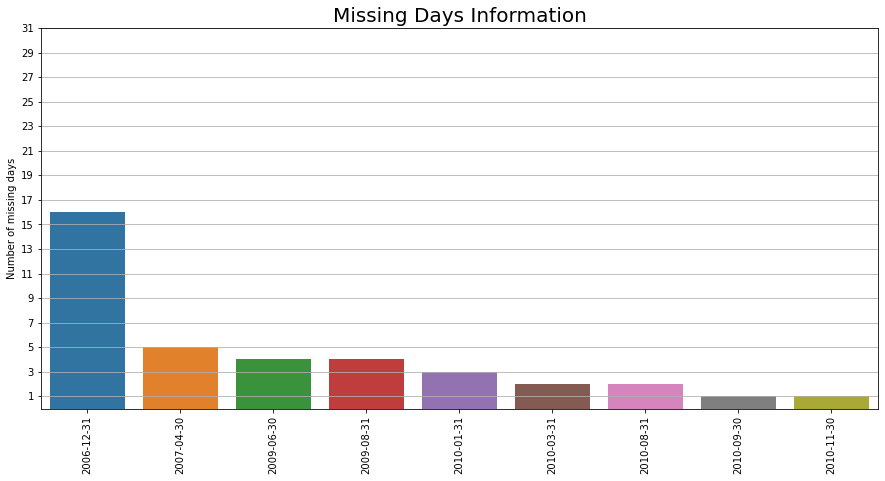

In [12]:
# Let's find out how many days have not been recored in our dataset
missing_days_df = np.round(df[['Global_active_power']].resample('m').count()/1440).astype(int)
missing_days_df.columns = ['Number of missing days']
missing_days_df['Number of missing days'] = missing_days_df.index.astype(str).str[-2:].astype(int) - missing_days_df['Number of missing days']
# Drop the rows where the number of missing days is 0
missing_days_df.drop(missing_days_df[missing_days_df['Number of missing days']==0].index,inplace=True)

# Drawing the plot
plt.figure(figsize=(15,7))
sns.barplot(
    data = missing_days_df,
    x = missing_days_df.index.date,
    y = missing_days_df.sort_values(by=['Number of missing days'],ascending=False)['Number of missing days']
)
plt.xticks(rotation = 90)
plt.yticks(np.arange(1,32,2))
plt.xlabel('')
plt.grid(axis='y')
plt.title('Missing Days Information',fontsize=20)
plt.show()

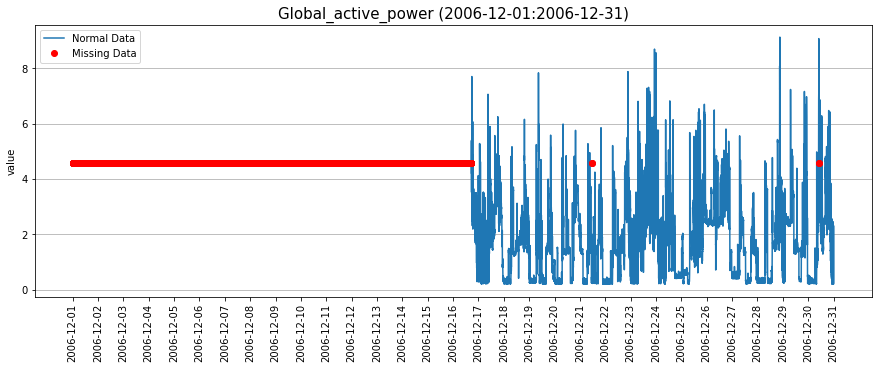

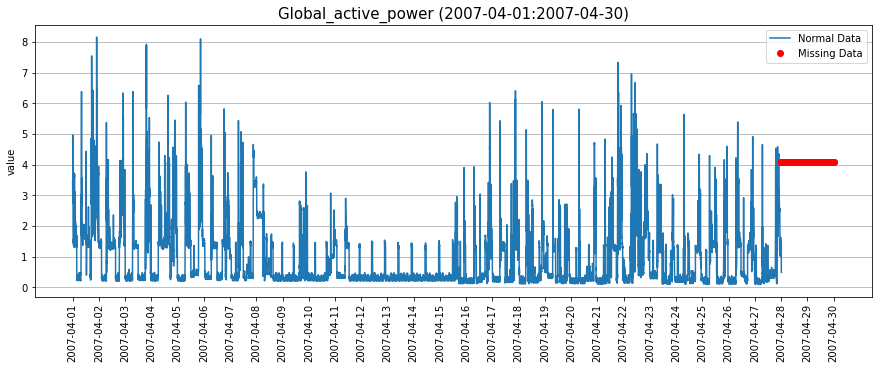

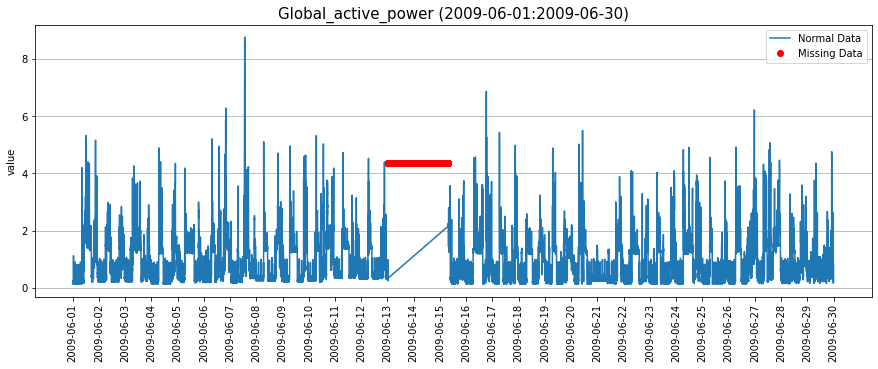

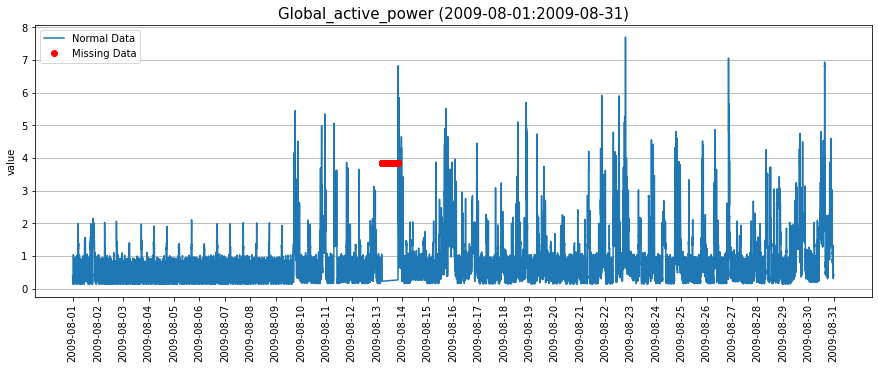

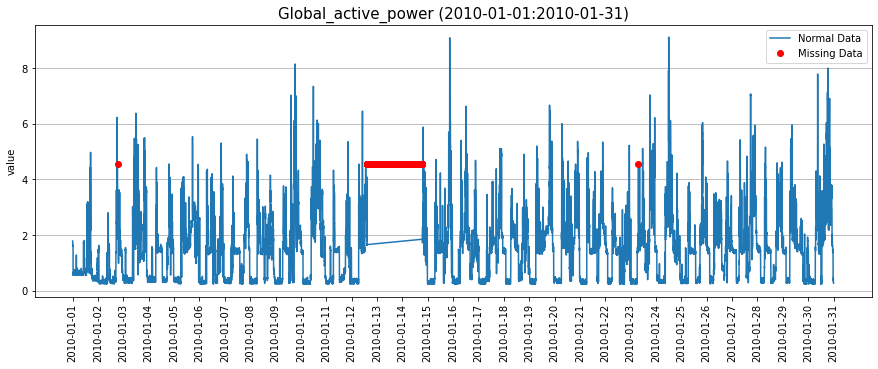

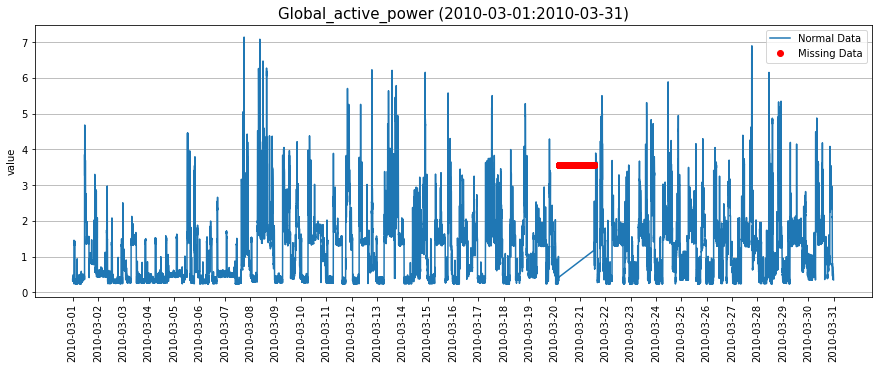

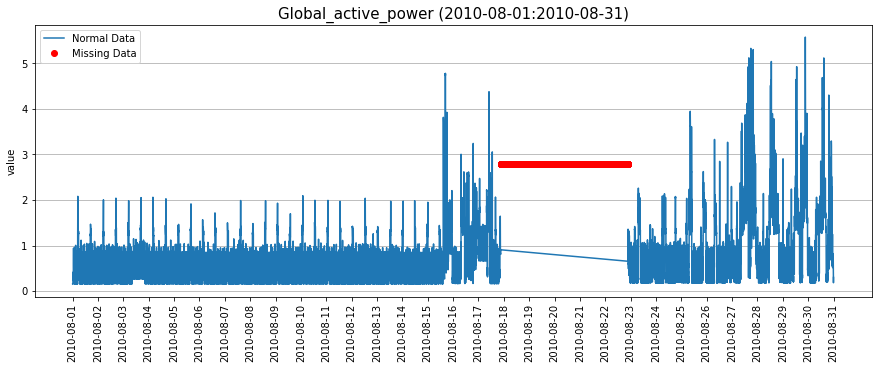

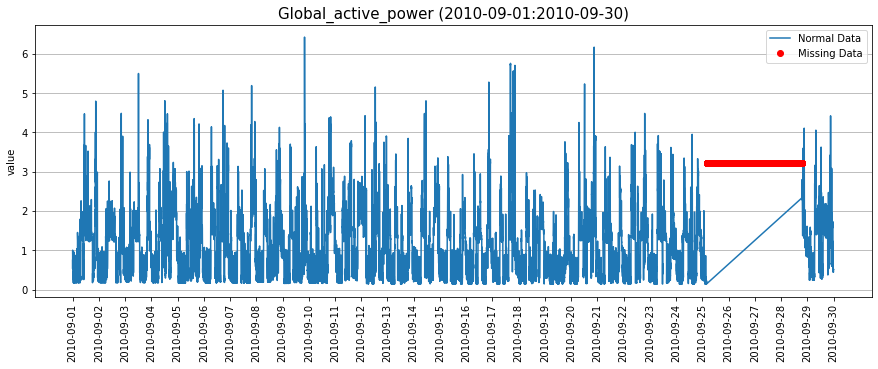

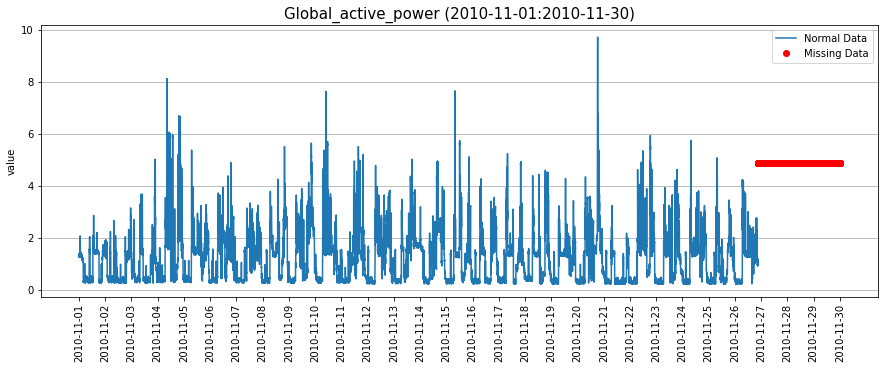

In [13]:
# Check missing data in all study variables 
for day in missing_days_df.index.date:
    plot_day_data(day)

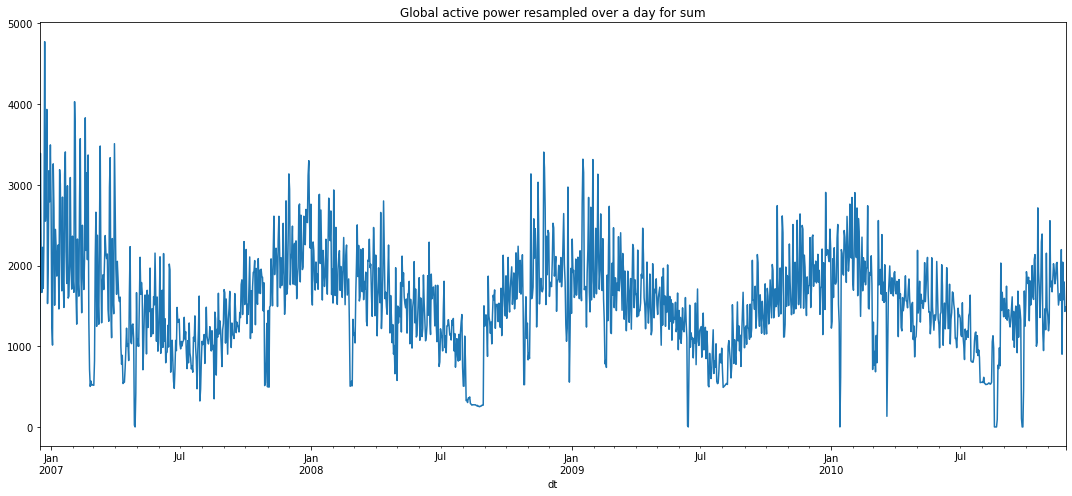

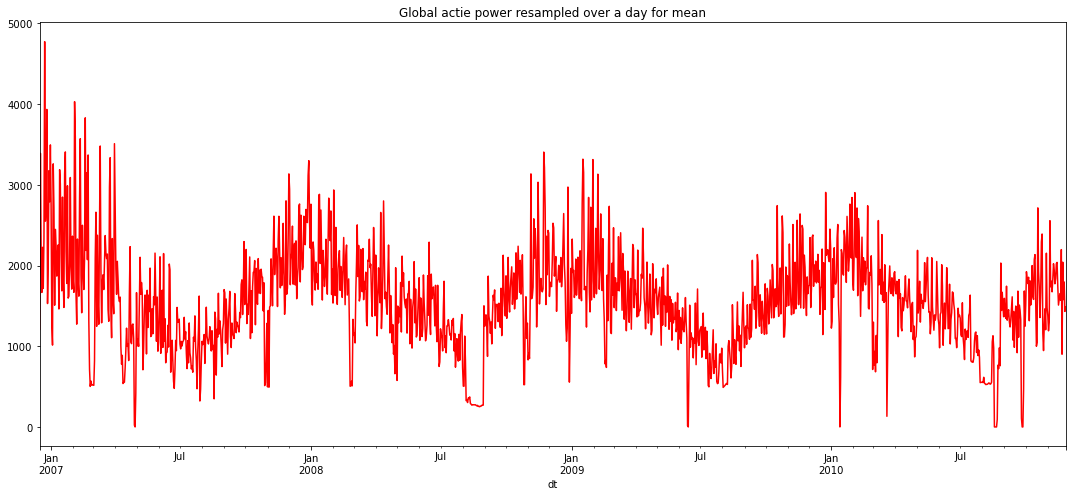

In [14]:
# Uniting time dates by minute to days 'Global active power'  

plt.figure(figsize=(15,7))
df.Global_active_power.resample('D').sum().plot(title = 'Global active power resampled over a day for sum')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,7))
df.Global_active_power.resample('D').sum().plot(title = 'Global actie power resampled over a day for mean', color = 'red')
plt.tight_layout()
plt.show()

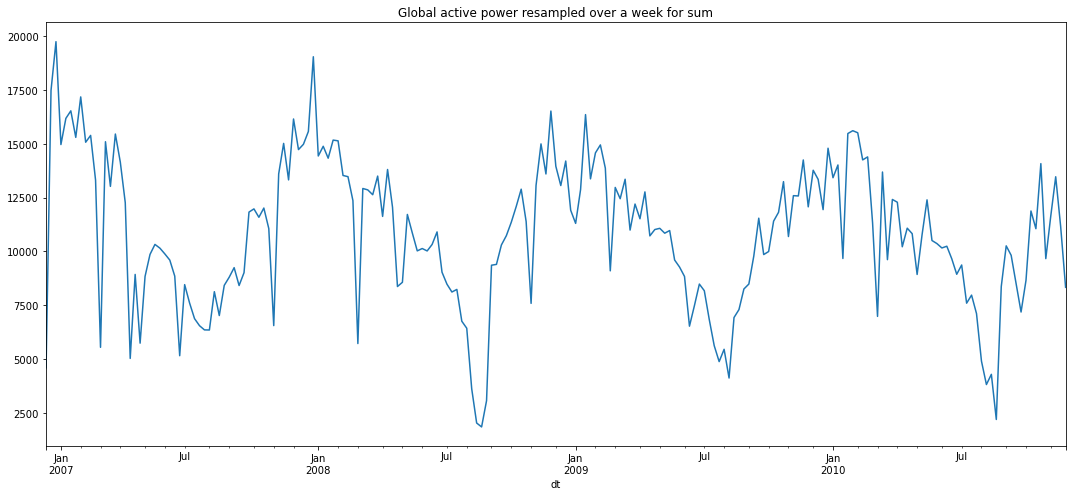

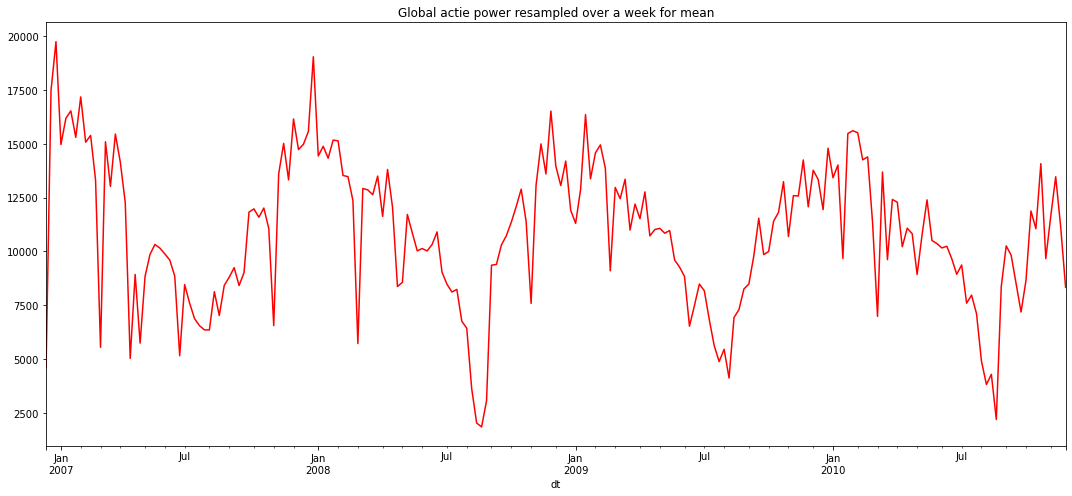

In [15]:
# Uniting time dates by weeks 'Global active power'  

plt.figure(figsize=(15,7))
df.Global_active_power.resample('W').sum().plot(title = 'Global active power resampled over a week for sum')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,7))
df.Global_active_power.resample('W').sum().plot(title = 'Global actie power resampled over a week for mean', color = 'red')
plt.tight_layout()
plt.show()

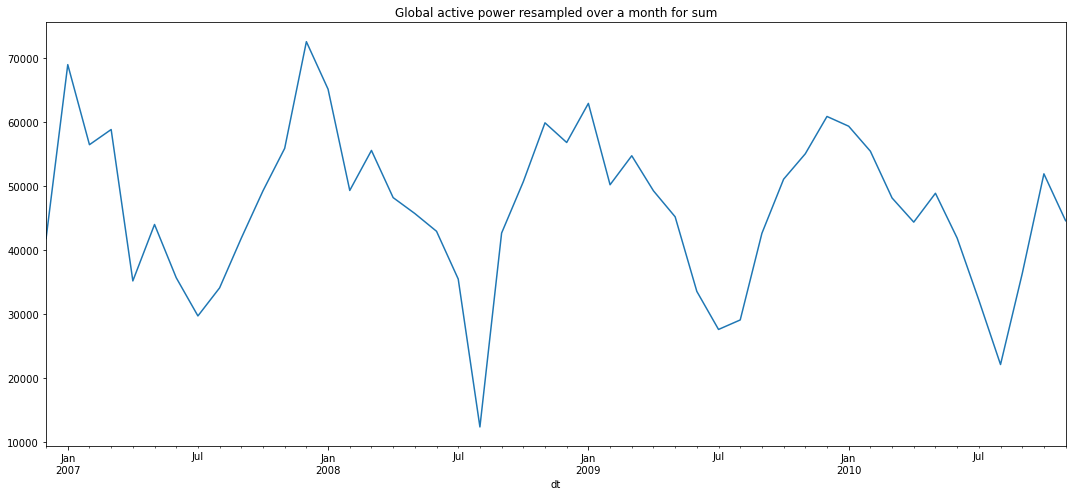

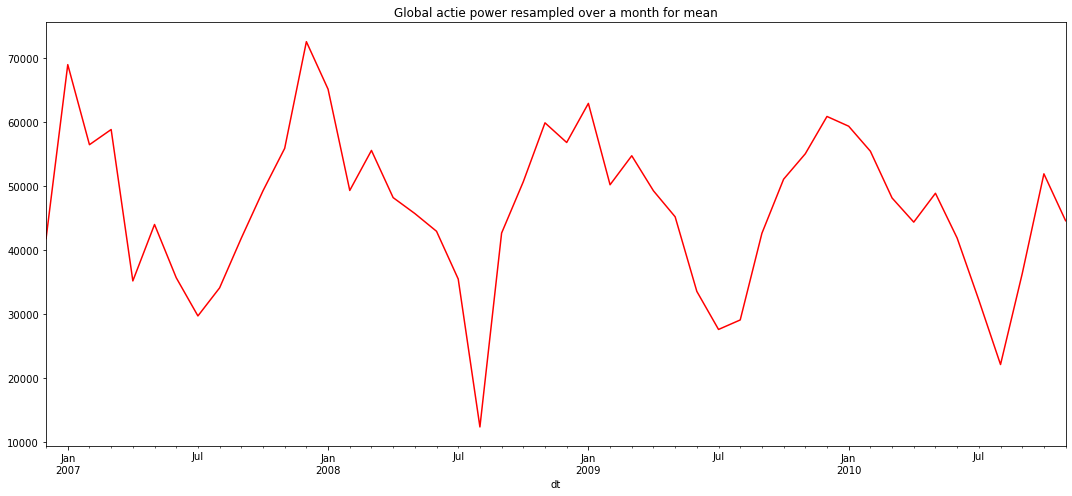

In [16]:
# uniting time dates by months 'Global active power'  

plt.figure(figsize=(15,7))
df.Global_active_power.resample('M').sum().plot(title = 'Global active power resampled over a month for sum')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,7))
df.Global_active_power.resample('M').sum().plot(title = 'Global actie power resampled over a month for mean', color = 'red')
plt.tight_layout()
plt.show()

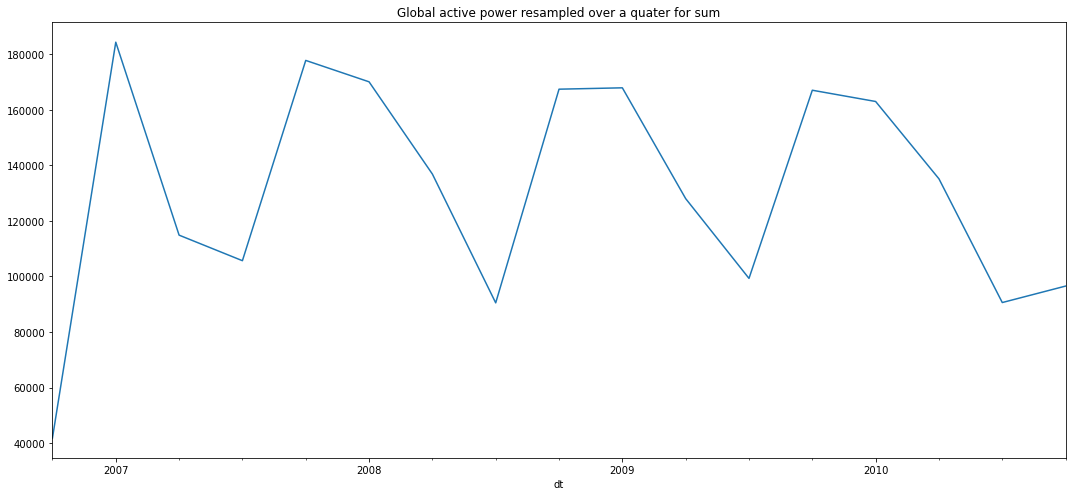

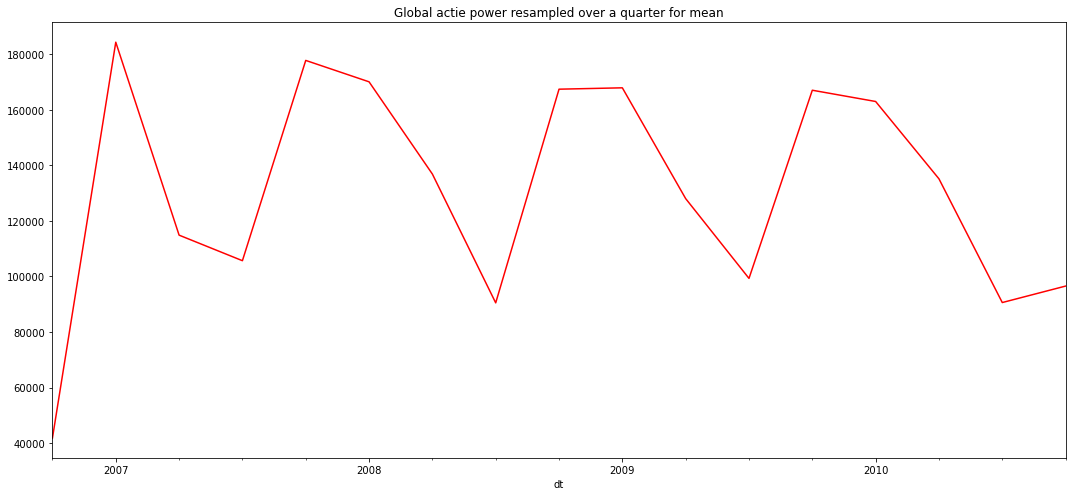

In [17]:
# uniting time dates by quarters'Global active power' 

plt.figure(figsize=(15,7))
df.Global_active_power.resample('Q').sum().plot(title = 'Global active power resampled over a quater for sum')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,7))
df.Global_active_power.resample('Q').sum().plot(title = 'Global actie power resampled over a quarter for mean', color = 'red')
plt.tight_layout()
plt.show()

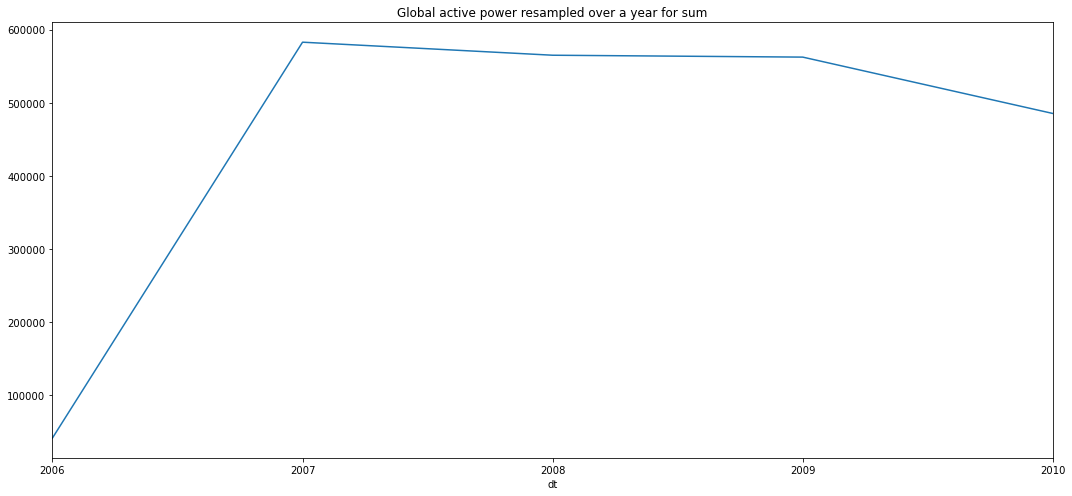

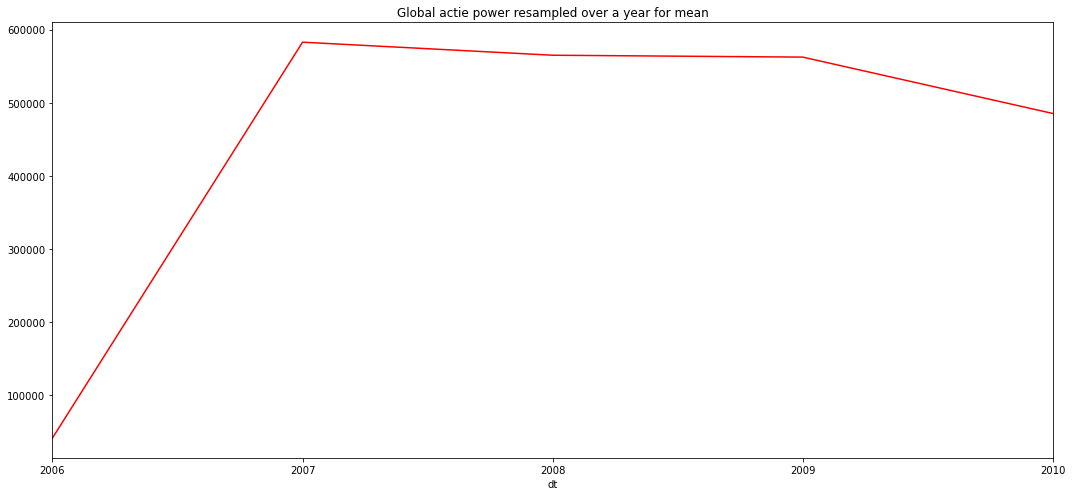

In [18]:
# uniting time dates by years 'Global active power'  

plt.figure(figsize=(15,7))
df.Global_active_power.resample('Y').sum().plot(title = 'Global active power resampled over a year for sum')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,7))
df.Global_active_power.resample('Y').sum().plot(title = 'Global actie power resampled over a year for mean', color = 'red')
plt.tight_layout()
plt.show()

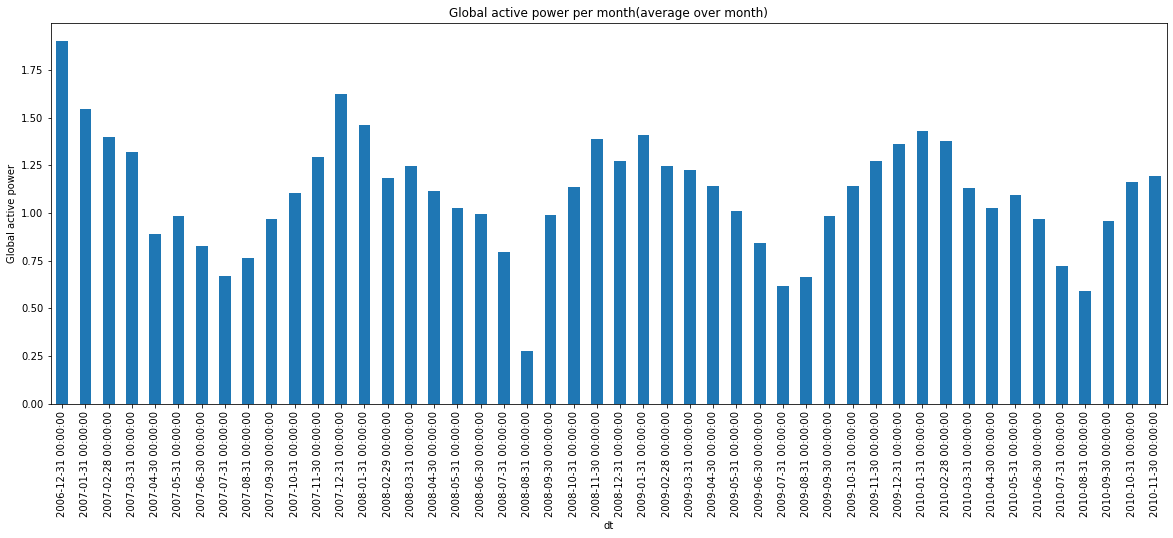

In [19]:
# resample by months 'Global active power'

plt.figure(figsize=(20,7))
df['Global_active_power'].resample('M').mean().plot(kind = 'bar')
plt.xticks(rotation = 90)
plt.ylabel('Global active power')
plt.title('Global active power per month(average over month)')
plt.show()

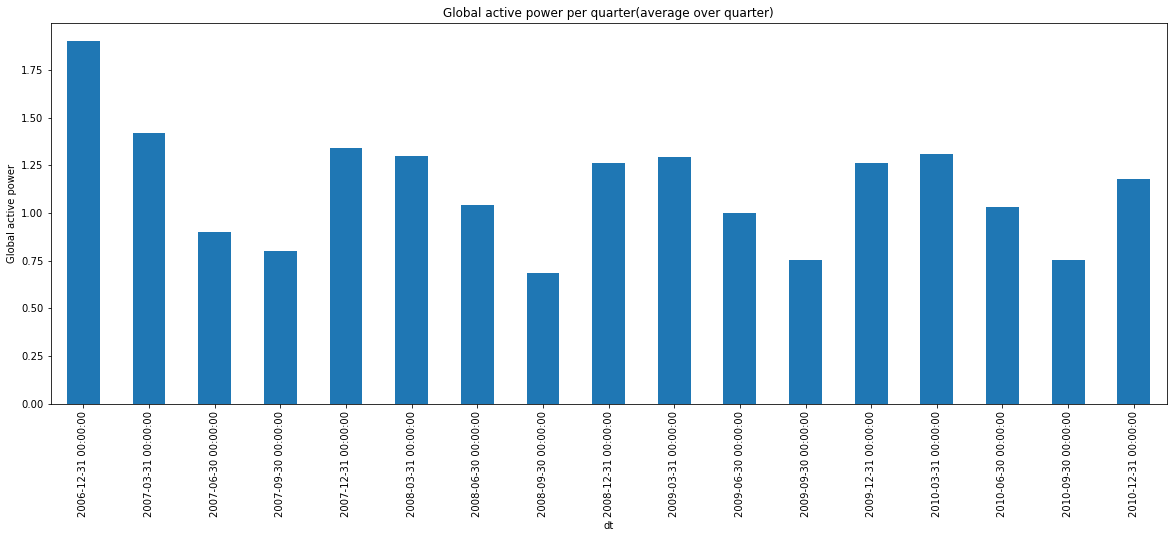

In [20]:
# resample by quartals 'Global active power'

plt.figure(figsize=(20,7))
df['Global_active_power'].resample('Q').mean().plot(kind = 'bar')
plt.xticks(rotation = 90)
plt.ylabel('Global active power')
plt.title('Global active power per quarter(average over quarter)')
plt.show()

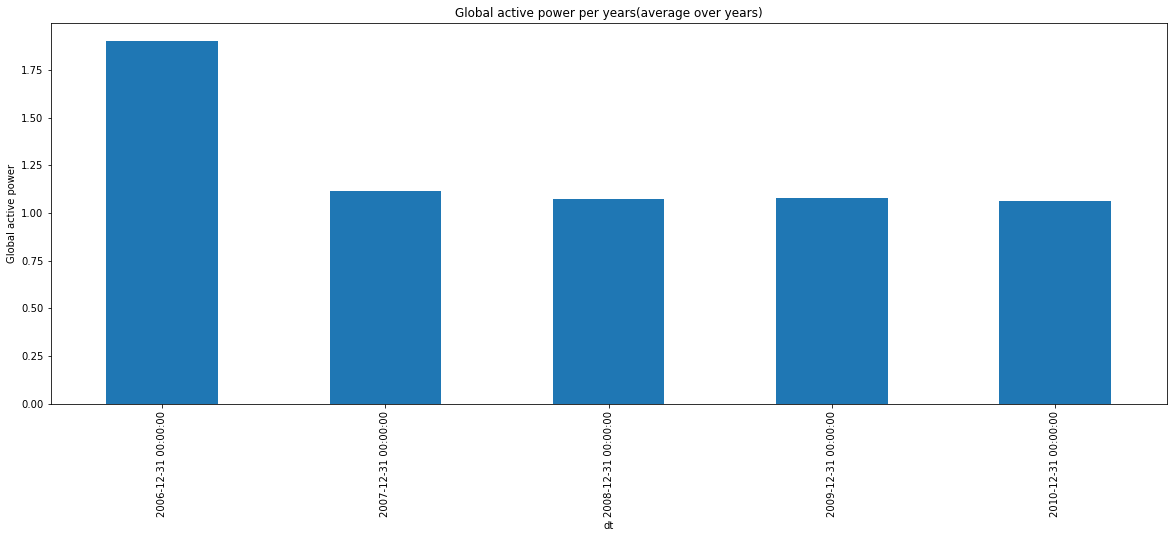

In [21]:
# resample by years 'Global active power'

plt.figure(figsize=(20,7))
df['Global_active_power'].resample('Y').mean().plot(kind = 'bar')
plt.xticks(rotation = 90)
plt.ylabel('Global active power')
plt.title('Global active power per years(average over years)')
plt.show()

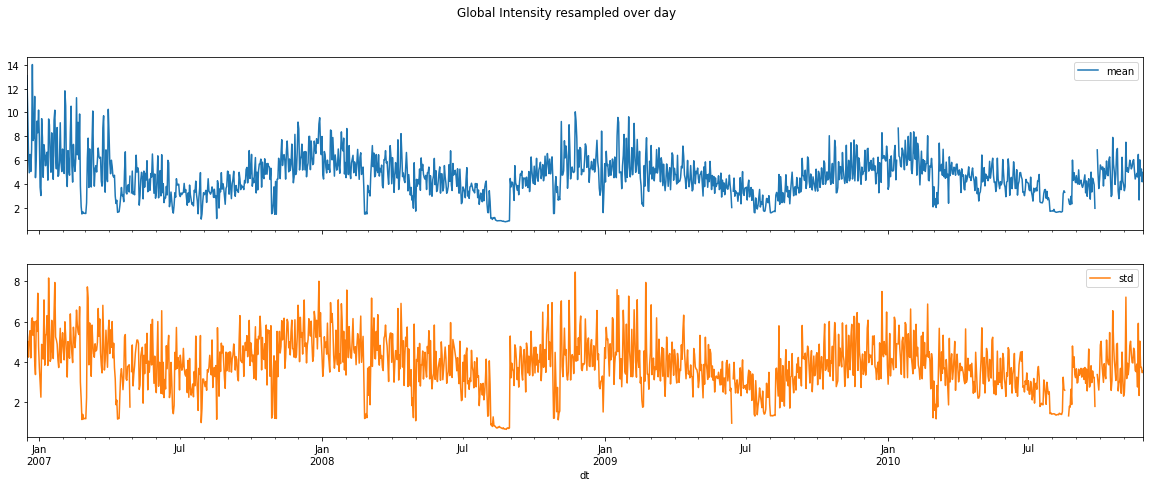

In [22]:
# let's see Global_intensity resampled by days based on mean and standard deviation

r = df.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title = 'Global Intensity resampled over day',figsize=(20,7))
plt.show()

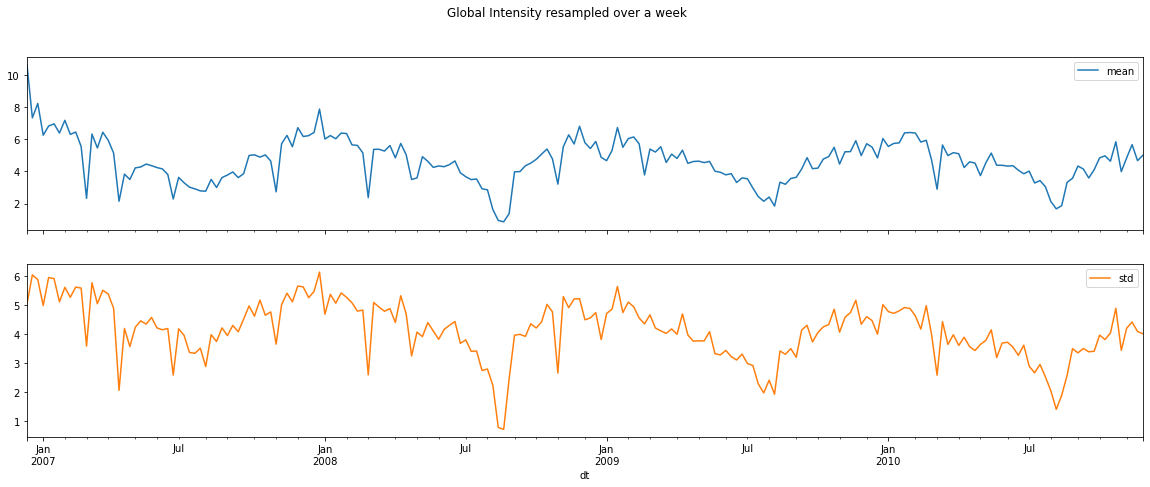

In [23]:
# resample by weeks Global_intensity

r = df.Global_intensity.resample('W').agg(['mean', 'std'])
r.plot(subplots = True, title = 'Global Intensity resampled over a week',figsize=(20,7))
plt.show()

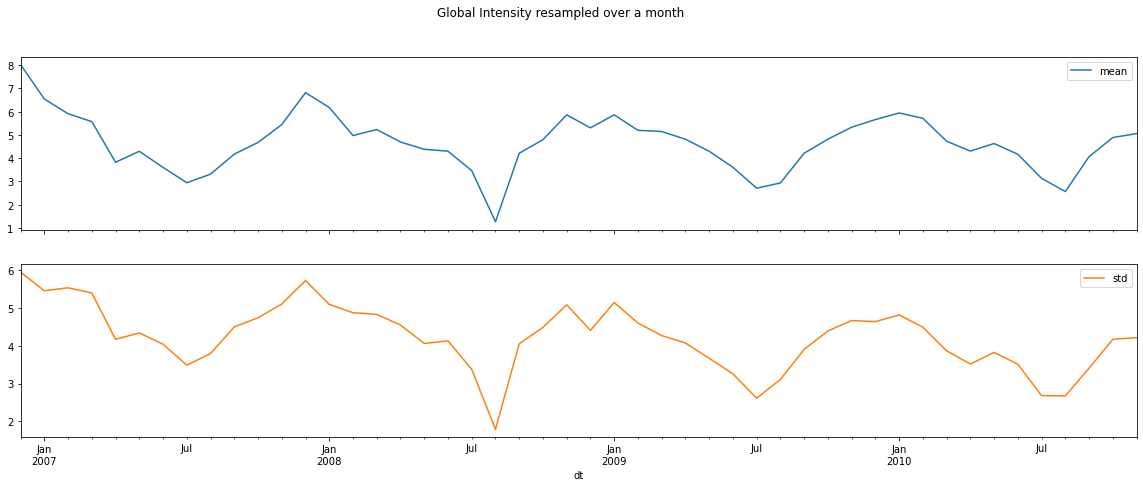

In [24]:
# resample by months Global_intensity

r = df.Global_intensity.resample('M').agg(['mean', 'std'])
r.plot(subplots = True, title = 'Global Intensity resampled over a month',figsize=(20,7))
plt.show()

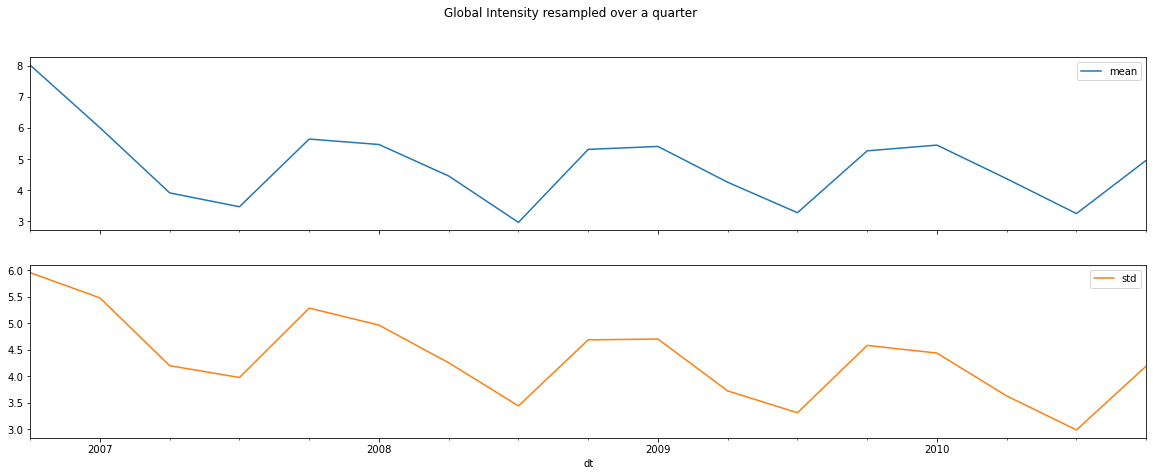

In [25]:
# resample by quarters Global_intensity

r = df.Global_intensity.resample('Q').agg(['mean', 'std'])
r.plot(subplots = True, title = 'Global Intensity resampled over a quarter',figsize=(20,7))
plt.show()

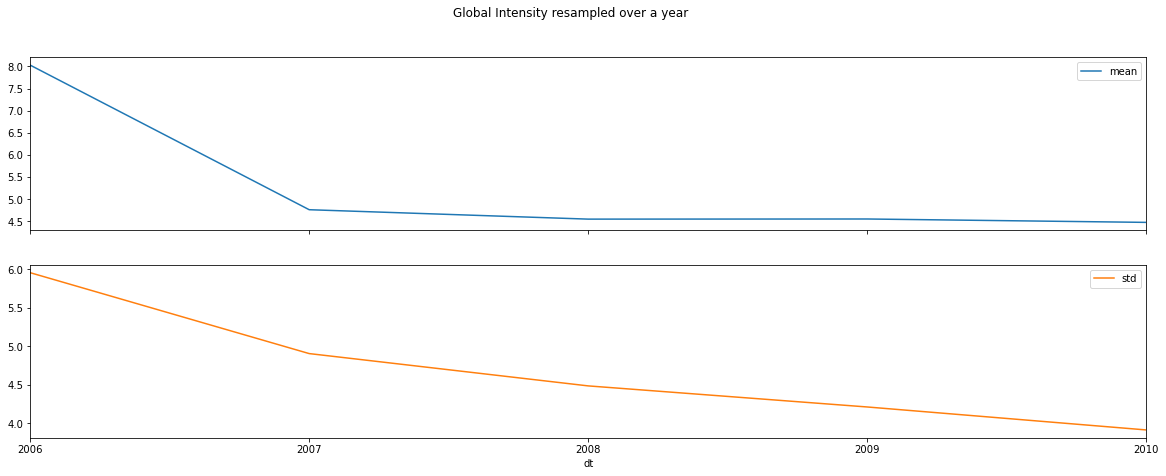

In [26]:
# resample by years Global_intensity

r = df.Global_intensity.resample('Y').agg(['mean', 'std'])
r.plot(subplots = True, title = 'Global Intensity resampled over a year',figsize=(20,7))
plt.show()

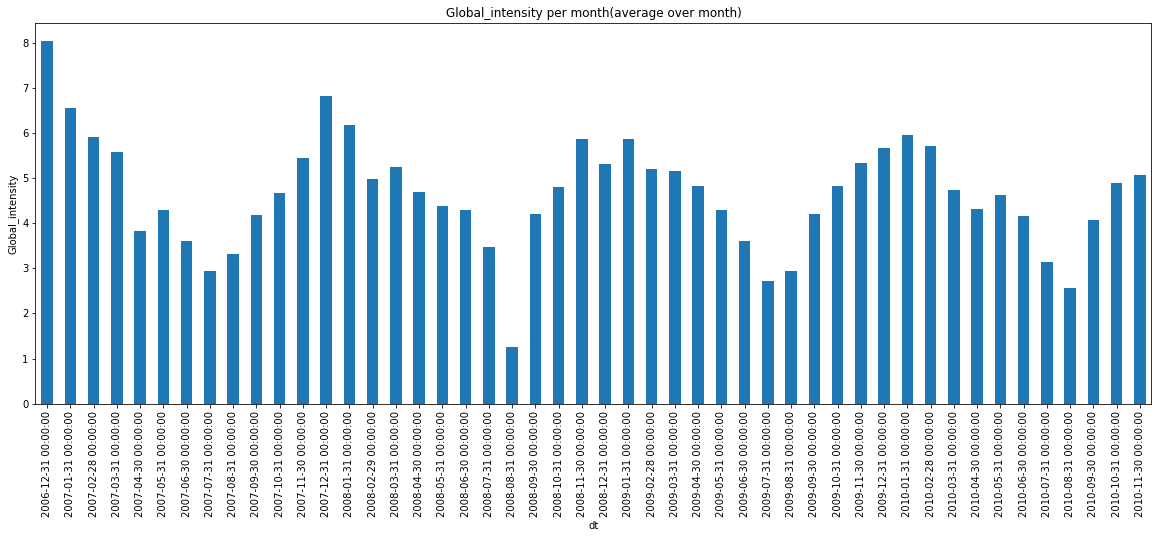

In [27]:
# resample by months Global_intensity

plt.figure(figsize=(20,7))
df['Global_intensity'].resample('M').mean().plot(kind = 'bar')
plt.xticks(rotation = 90)
plt.ylabel('Global_intensity')
plt.title('Global_intensity per month(average over month)')
plt.show()

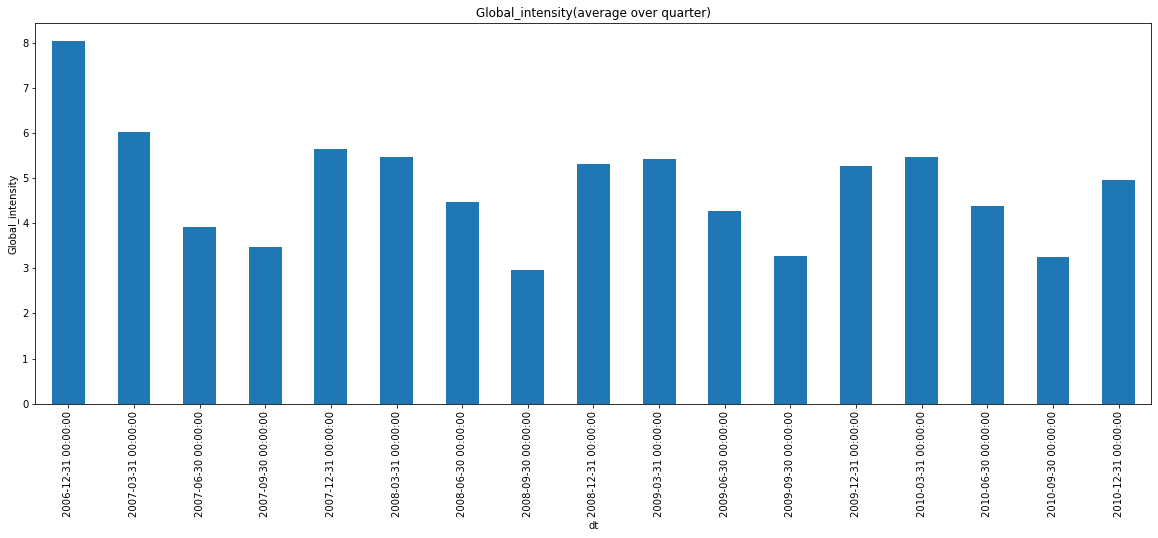

In [28]:
# resample by quartals Global_intensity

plt.figure(figsize=(20,7))
df['Global_intensity'].resample('Q').mean().plot(kind = 'bar')
plt.xticks(rotation = 90)
plt.ylabel('Global_intensity')
plt.title('Global_intensity(average over quarter)')
plt.show()

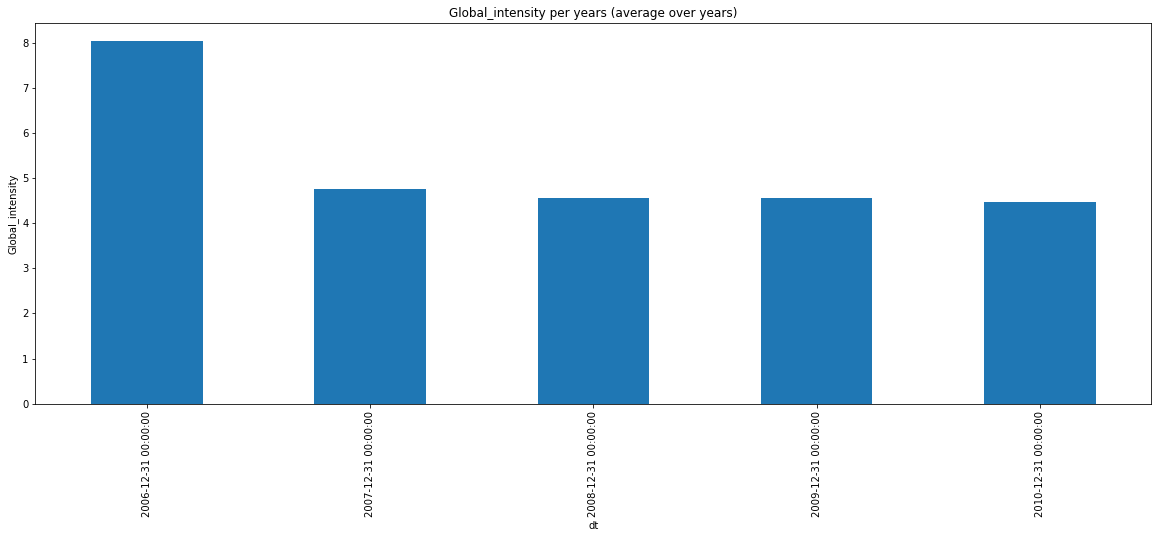

In [29]:
# resample by years 'Global_intensity'

plt.figure(figsize=(20,7))
df['Global_intensity'].resample('Y').mean().plot(kind = 'bar')
plt.xticks(rotation = 90)
plt.ylabel('Global_intensity')
plt.title('Global_intensity per years (average over years)')
plt.show()

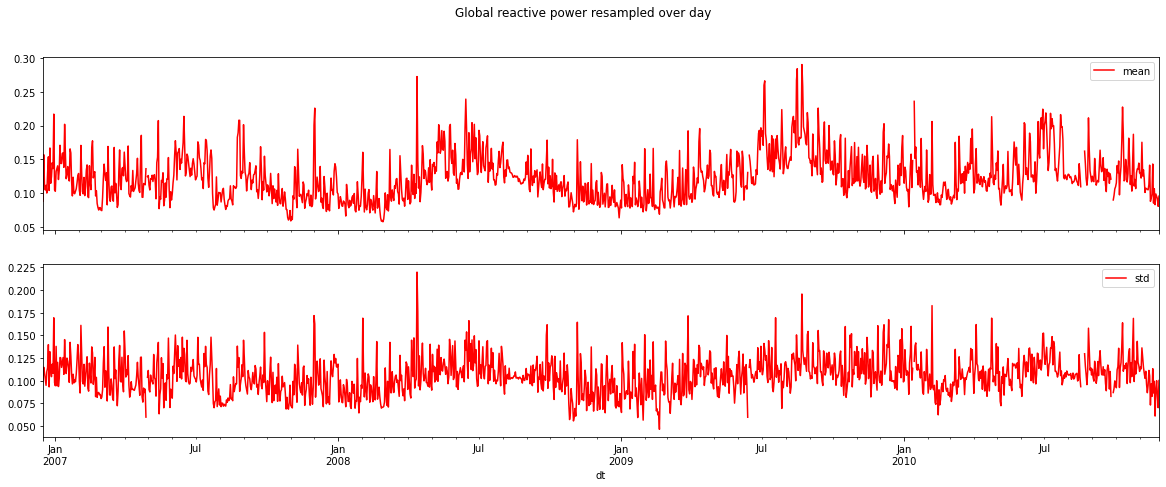

In [30]:
# resample by days 'Global_reactive_power'

r2 = df.Global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title = 'Global reactive power resampled over day', color = 'red', figsize=(20,7))
plt.show()

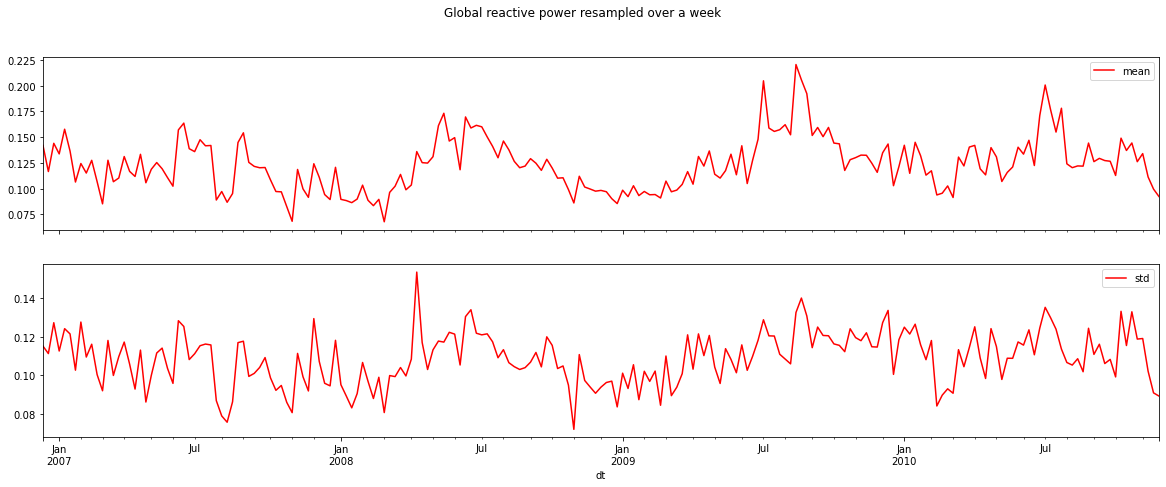

In [31]:
# resample by weeks 'Global_reactive_power'

r2 = df.Global_reactive_power.resample('W').agg(['mean', 'std'])
r2.plot(subplots = True, title = 'Global reactive power resampled over a week', color = 'red', figsize=(20,7))
plt.show()

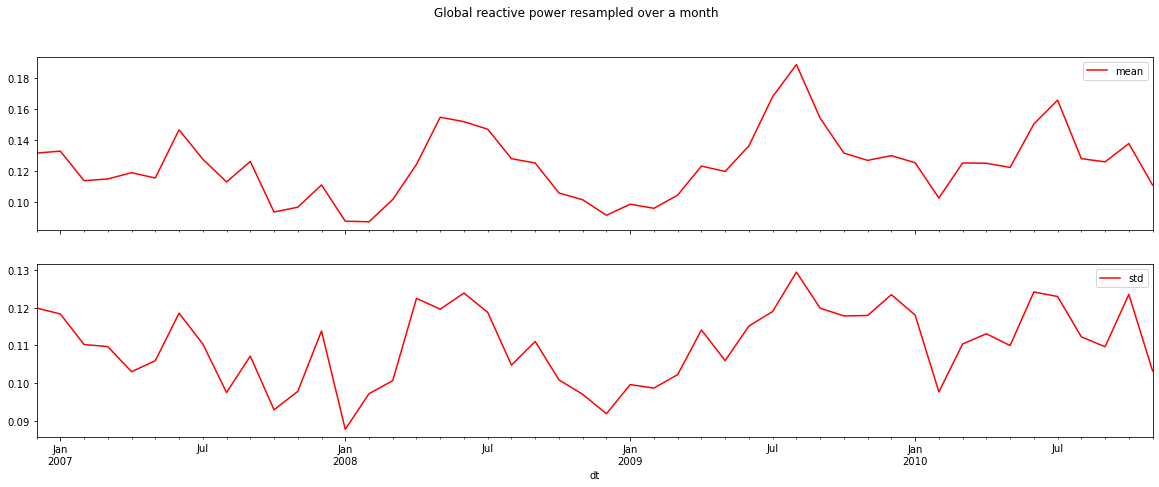

In [32]:
# resample by months 'Global_reactive_power'

r2 = df.Global_reactive_power.resample('M').agg(['mean', 'std'])
r2.plot(subplots = True, title = 'Global reactive power resampled over a month', color = 'red', figsize=(20,7))
plt.show()

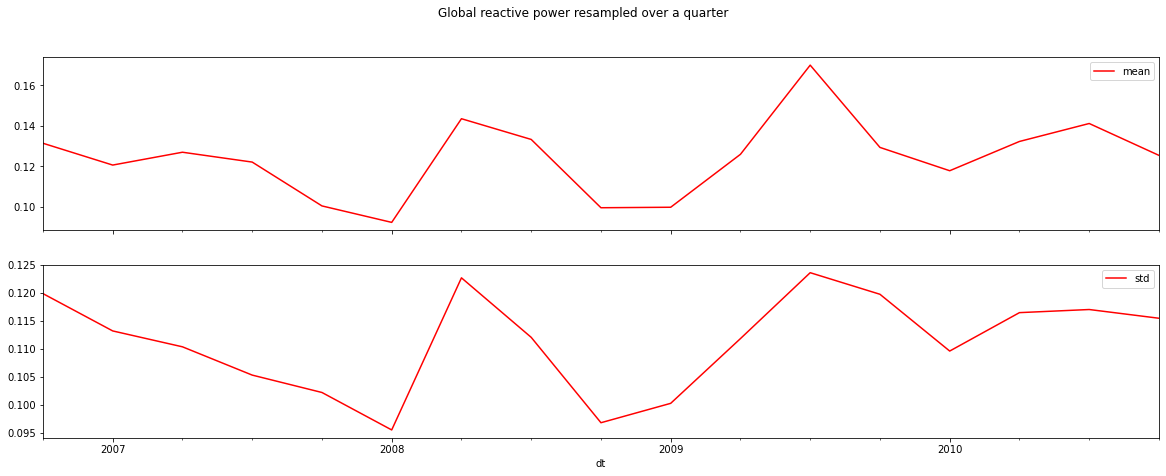

In [33]:
# resample by quarters 'Global_reactive_power'

r2 = df.Global_reactive_power.resample('Q').agg(['mean', 'std'])
r2.plot(subplots = True, title = 'Global reactive power resampled over a quarter', color = 'red', figsize=(20,7))
plt.show()

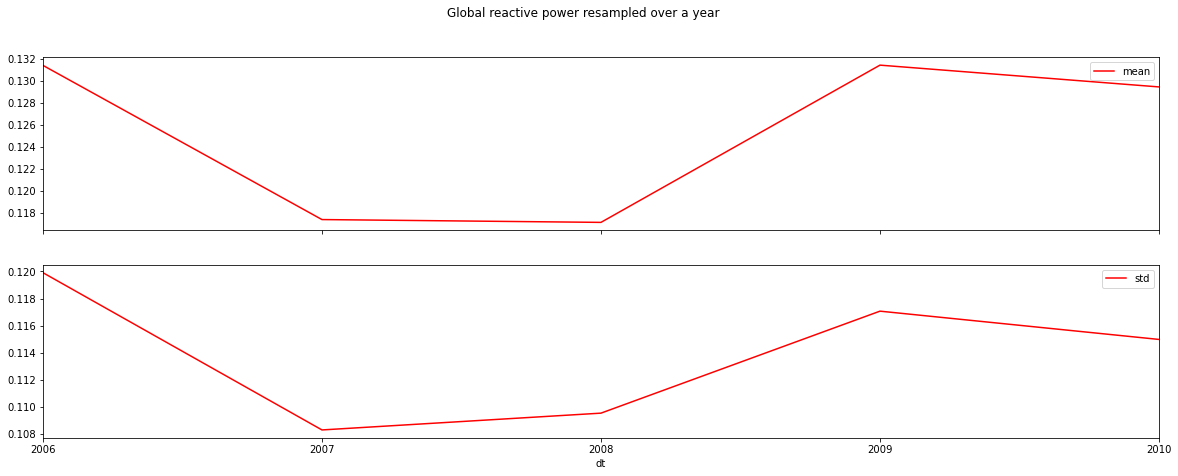

In [34]:
# resample by years 'Global_reactive_power'

r2 = df.Global_reactive_power.resample('Y').agg(['mean', 'std'])
r2.plot(subplots = True, title = 'Global reactive power resampled over a year', color = 'red', figsize=(20,7))
plt.show()

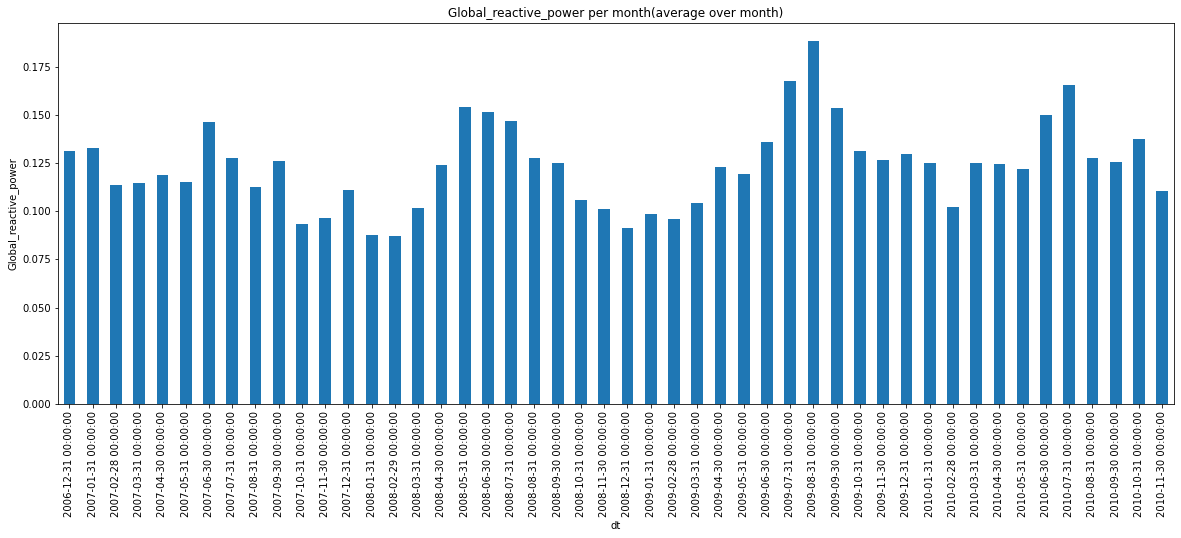

In [35]:
# resample by months 'Global_reactive_power'

plt.figure(figsize=(20,7))
df['Global_reactive_power'].resample('M').mean().plot(kind = 'bar')
plt.xticks(rotation = 90)
plt.ylabel('Global_reactive_power')
plt.title('Global_reactive_power per month(average over month)')
plt.show()

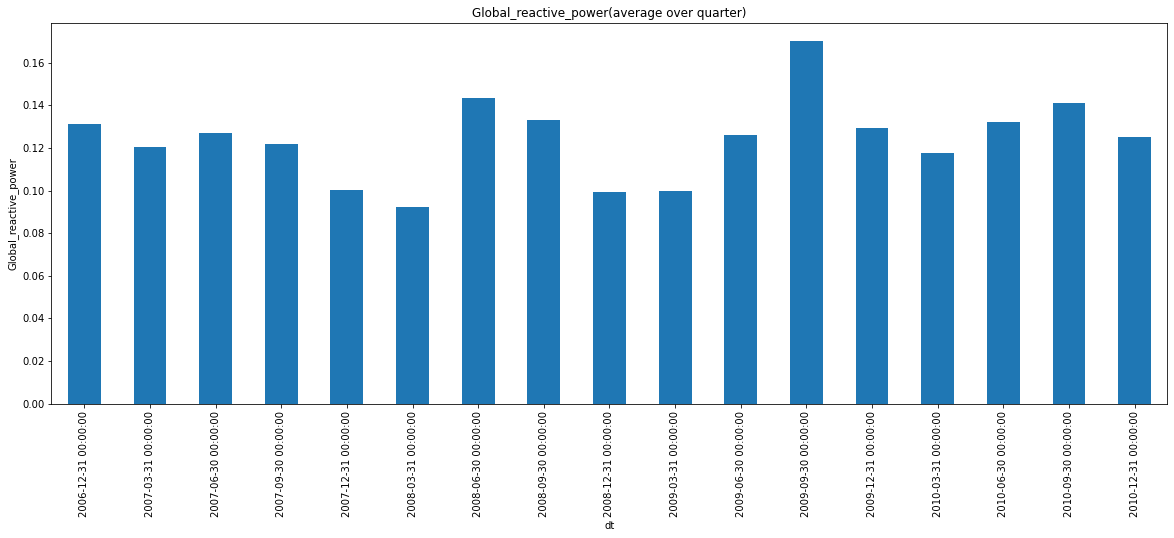

In [36]:
# resample by quartals 'Global_reactive_power'

plt.figure(figsize=(20,7))
df['Global_reactive_power'].resample('Q').mean().plot(kind = 'bar')
plt.xticks(rotation = 90)
plt.ylabel('Global_reactive_power')
plt.title('Global_reactive_power(average over quarter)')
plt.show()

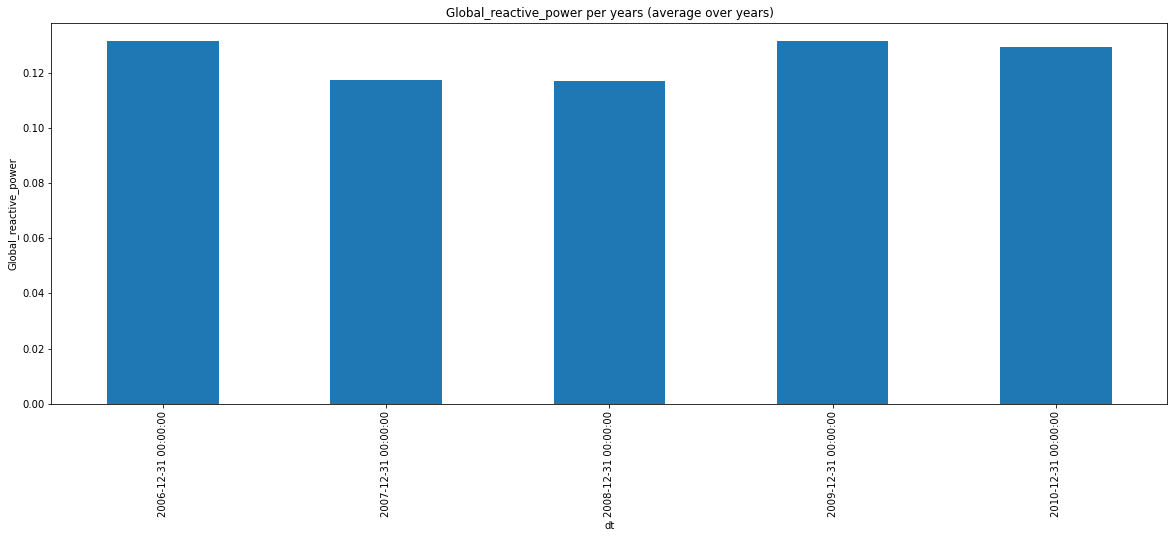

In [37]:
# resample by years 'Global_reactive_power'

plt.figure(figsize=(20,7))
df['Global_reactive_power'].resample('Y').mean().plot(kind = 'bar')
plt.xticks(rotation = 90)
plt.ylabel('Global_reactive_power')
plt.title('Global_reactive_power per years (average over years)')
plt.show()

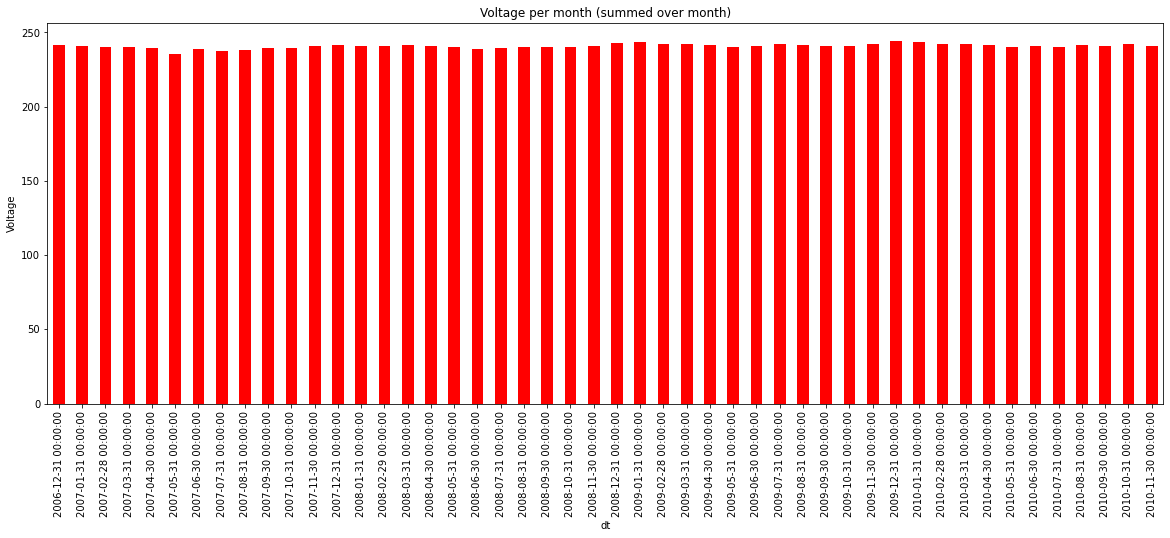

In [38]:
# another variable 'Voltage'

plt.figure(figsize=(20,7))
df['Voltage'].resample('M').mean().plot(kind = 'bar', color = 'red')
plt.xticks(rotation = 90)
plt.ylabel('Voltage')
plt.title('Voltage per month (summed over month)')
plt.show()

# as we can see the voltage amount is the same over months, hence we can remove this factor from the study part, no impact

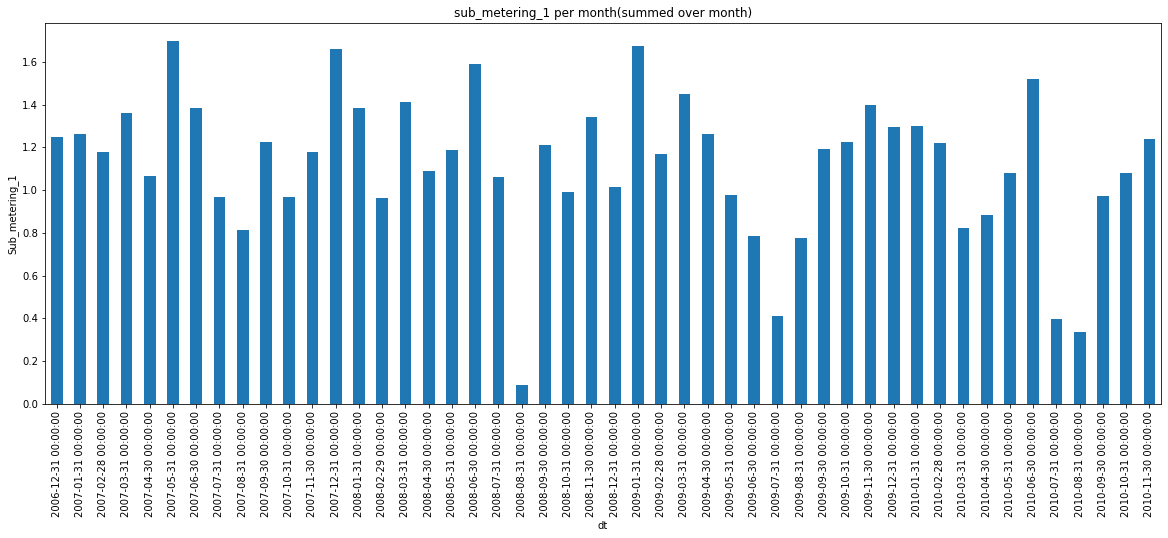

In [39]:
# resample by months 'sub metering1' variable

plt.figure(figsize=(20,7))
df['Sub_metering_1'].resample('M').mean().plot(kind = 'bar')
plt.xticks(rotation = 90)
plt.ylabel('Sub_metering_1')
plt.title('sub_metering_1 per month(summed over month)')
plt.show()


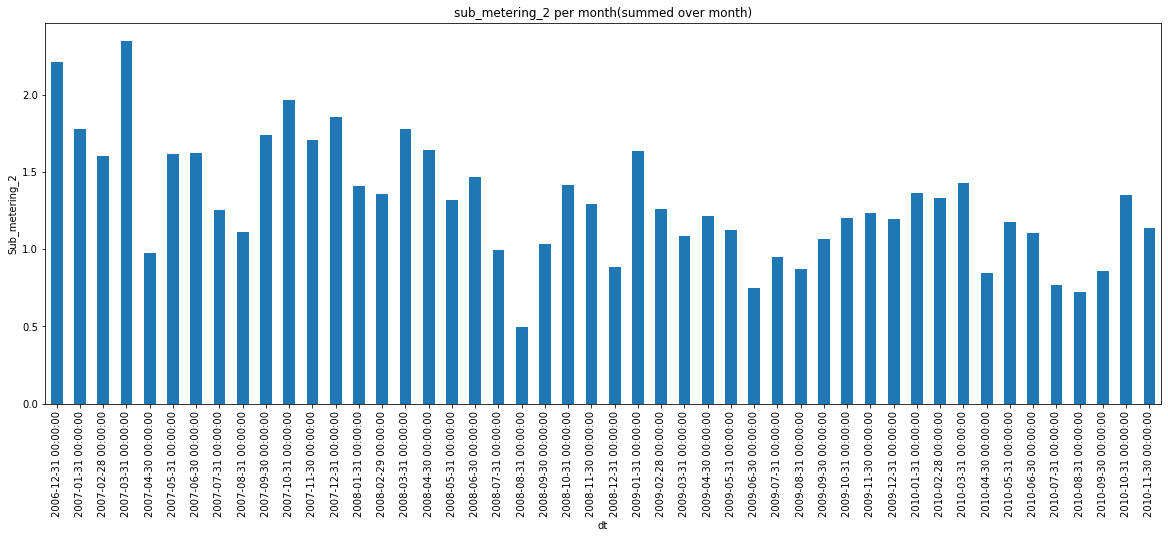

In [40]:
# resample by months 'sub metering2' variable


plt.figure(figsize=(20,7))
df['Sub_metering_2'].resample('M').mean().plot(kind = 'bar')
plt.xticks(rotation = 90)
plt.ylabel('Sub_metering_2')
plt.title('sub_metering_2 per month(summed over month)')
plt.show()


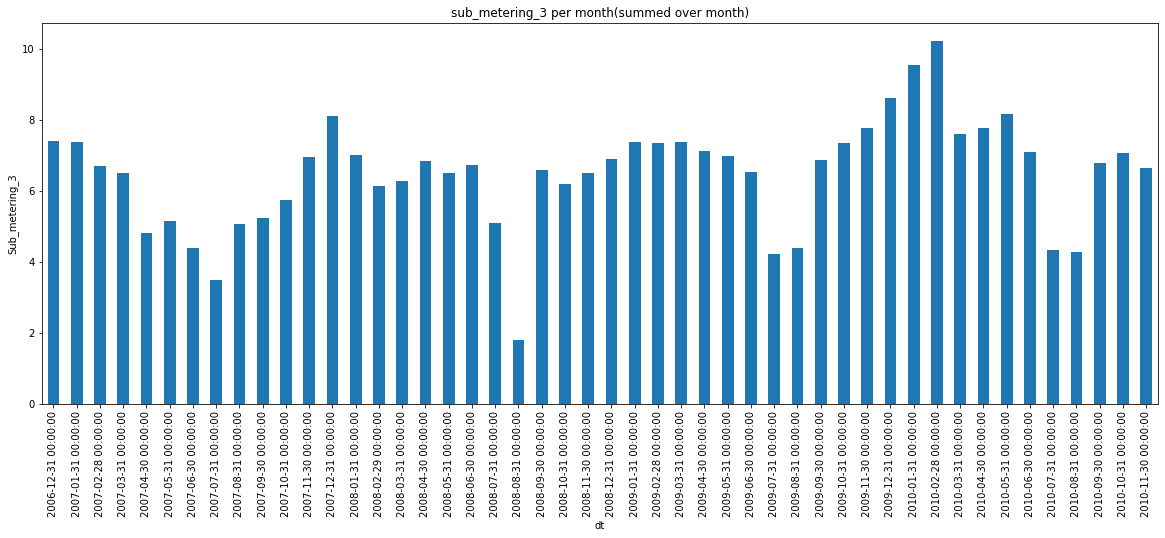

In [41]:
# resample by months 'sub metering3' variable


plt.figure(figsize=(20,7))
df['Sub_metering_3'].resample('M').mean().plot(kind = 'bar')
plt.xticks(rotation = 90)
plt.ylabel('Sub_metering_3')
plt.title('sub_metering_3 per month(summed over month)')
plt.show()


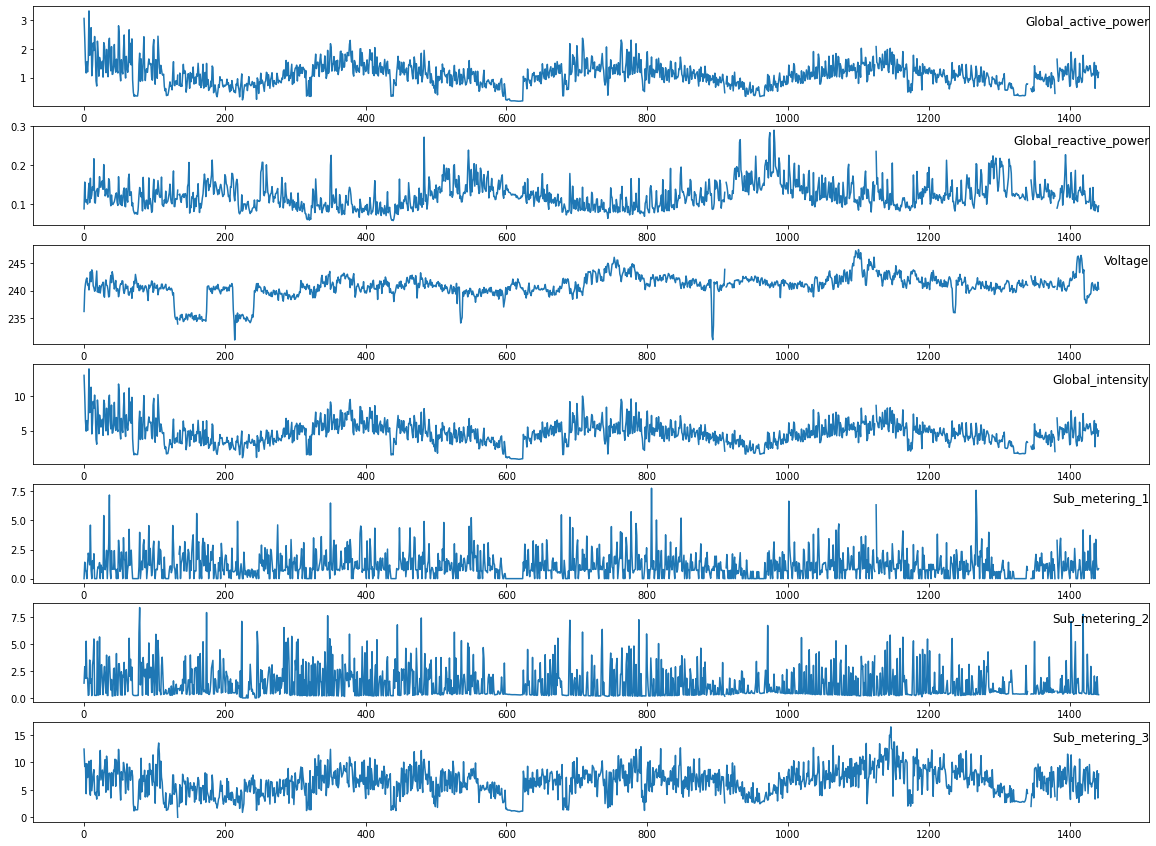

In [42]:
# compering mean in all variables during the day 

cols = [0, 1, 2, 3, 4, 5, 6]
i = 1 
groups = cols 

values = df.resample('D').mean().values 

plt.figure(figsize = (20, 15))

for group in groups:
    plt.subplot(len(cols), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y = 0.75, loc = 'right')
    i+=1

plt.show()

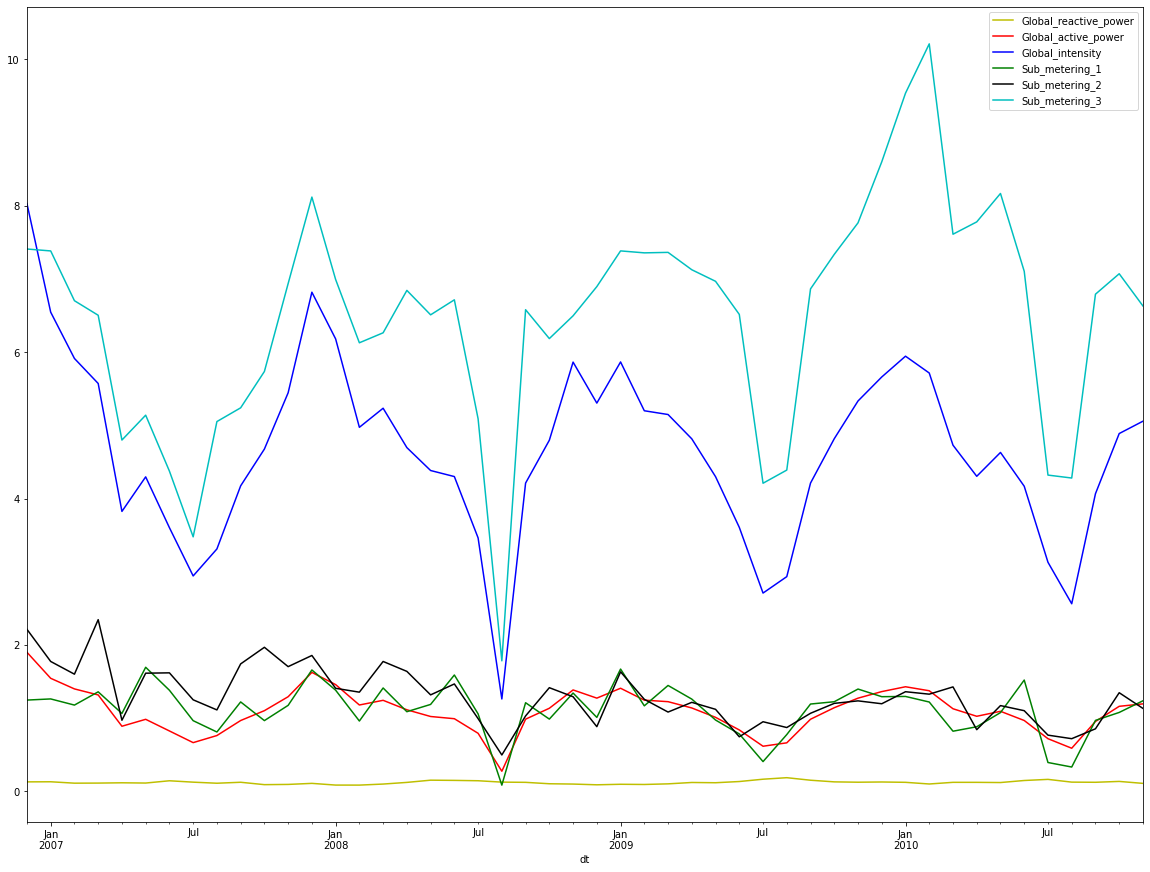

In [43]:
# compering mean in all variables during the week 

plt.figure(figsize = (20, 15))
df.Global_reactive_power.resample('M').mean().plot(color = 'y', legend = True)
df.Global_active_power.resample('M').mean().plot(color = 'r', legend = True)
df.Global_intensity.resample('M').mean().plot(color = 'b', legend = True)
df.Sub_metering_1.resample('M').mean().plot(color = 'g', legend = True)
df.Sub_metering_2.resample('M').mean().plot(color = 'k', legend = True)
df.Sub_metering_3.resample('M').mean().plot(color = 'c', legend = True)
plt.show()

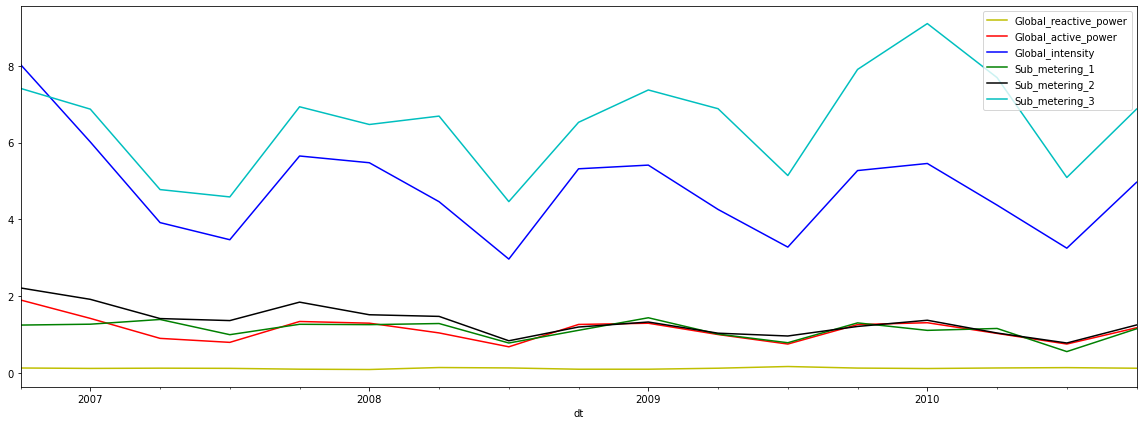

In [44]:
# compering mean in all variables during the Quarter 

plt.figure(figsize = (20, 7))
df.Global_reactive_power.resample('Q').mean().plot(color = 'y', legend = True)
df.Global_active_power.resample('Q').mean().plot(color = 'r', legend = True)
df.Global_intensity.resample('Q').mean().plot(color = 'b', legend = True)
df.Sub_metering_1.resample('Q').mean().plot(color = 'g', legend = True)
df.Sub_metering_2.resample('Q').mean().plot(color = 'k', legend = True)
df.Sub_metering_3.resample('Q').mean().plot(color = 'c', legend = True)
plt.show()

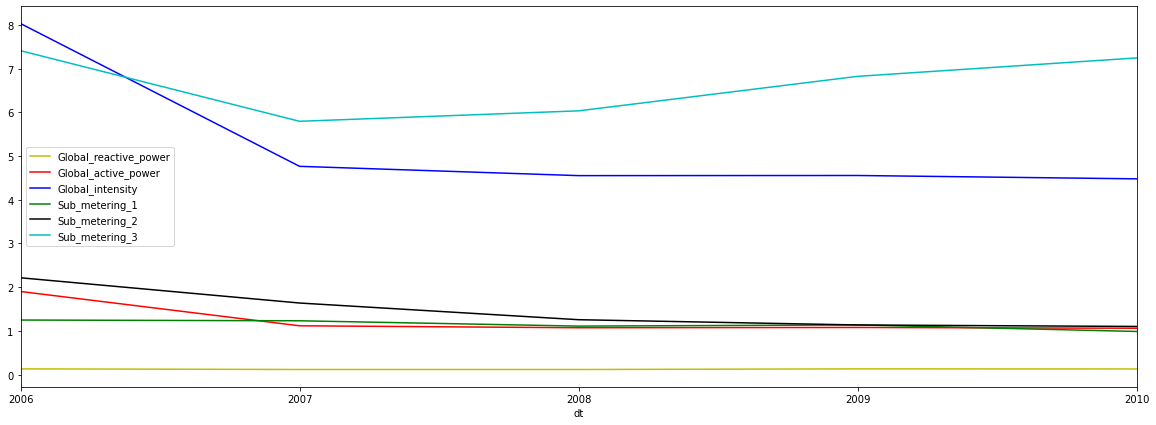

In [45]:
# compering mean in all variables during the year 

plt.figure(figsize = (20, 7))
df.Global_reactive_power.resample('Y').mean().plot(color = 'y', legend = True)
df.Global_active_power.resample('Y').mean().plot(color = 'r', legend = True)
df.Global_intensity.resample('Y').mean().plot(color = 'b', legend = True)
df.Sub_metering_1.resample('Y').mean().plot(color = 'g', legend = True)
df.Sub_metering_2.resample('Y').mean().plot(color = 'k', legend = True)
df.Sub_metering_3.resample('Y').mean().plot(color = 'c', legend = True)
plt.show()

## Step 4. Data preprocessing


In [46]:
# visualizing data

df

Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  
dt                                   
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0  
...                             ...  
2010-11-26 20:58:00             0.0  
2010-11-26 20:59:00             0.0  
2010-11-26 21:00:00             0.0  
2010-11-26 21:01:00             0.0  
2010-11-26 21:02:00             0.0  

[2075259 rows x 7 columns]

In [47]:
#function to stride timeseries

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):  #n_in, n_out stride for timeseries, 
    n_vars = 1 if type (data) is list else data.shape[1]
    
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d' % (j+1, i)) for j in range (n_vars)]
    for i in range (0, n_out):
        cols.append(dff.shift(-1))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range (n_vars)] 
        else:
            names +=[('var%d(t+%d)'% (j+1, i)) for j in range (n_vars)]
    
    agg = pd.concat(cols, axis = 1)
    agg.columns = names 
    
    if dropnan:
        agg.dropna(inplace = True)
    return agg 

In [48]:
# aggregate data for an hour, stride one hour in case if we put 'W' stride prediction will be for one week

df_resample = df.resample('h').mean()
df_resample.shape

(34589, 7)

In [49]:
# Resample data by average daily consumption

df = df.resample('D').mean()
df.describe().T

count        mean       std         min         25%  \
Global_active_power    1433.0    1.092048  0.420415    0.173818    0.816776   
Global_reactive_power  1433.0    0.123816  0.034131    0.057811    0.099188   
Voltage                1433.0  240.836421  2.045493  231.088229  240.094778   
Global_intensity       1433.0    4.629728  1.741352    0.808333    3.503333   
Sub_metering_1         1433.0    1.123143  1.113913    0.000000    0.440972   
Sub_metering_2         1433.0    1.298620  1.461039    0.000000    0.299306   
Sub_metering_3         1433.0    6.444100  2.568978    0.000000    4.638889   

                              50%         75%         max  
Global_active_power      1.080732    1.323926    3.314851  
Global_reactive_power    0.119092    0.141454    0.290162  
Voltage                240.965688  241.878583  247.435007  
Global_intensity         4.556111    5.540556   14.028056  
Sub_metering_1           0.775694    1.545139    7.767894  
Sub_metering_2           0.479167    1.897222    8.409028  
Sub_metering_3           6.447222    8.155556   16.488194

In [50]:
# Impute missing values with median value

imputer_median = MeanMedianImputer()
imputer_median.fit(df)

# Transform
df = imputer_median.transform(df)

In [51]:
# Check again the presence of missing values

df.isnull().mean()

Global_active_power      0.0
Global_reactive_power    0.0
Voltage                  0.0
Global_intensity         0.0
Sub_metering_1           0.0
Sub_metering_2           0.0
Sub_metering_3           0.0
dtype: float64

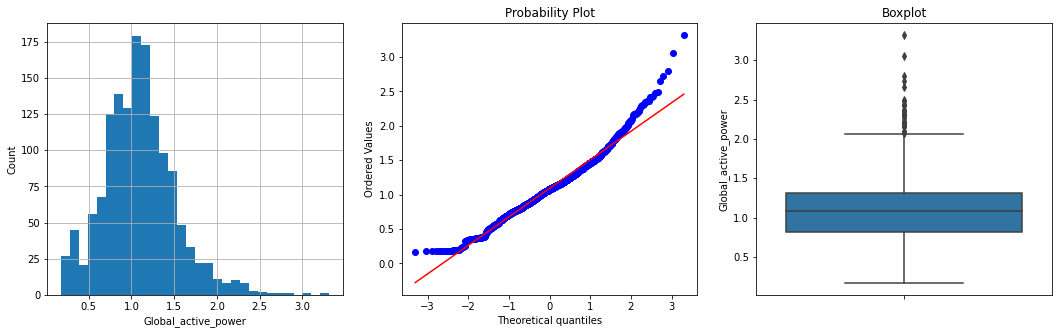

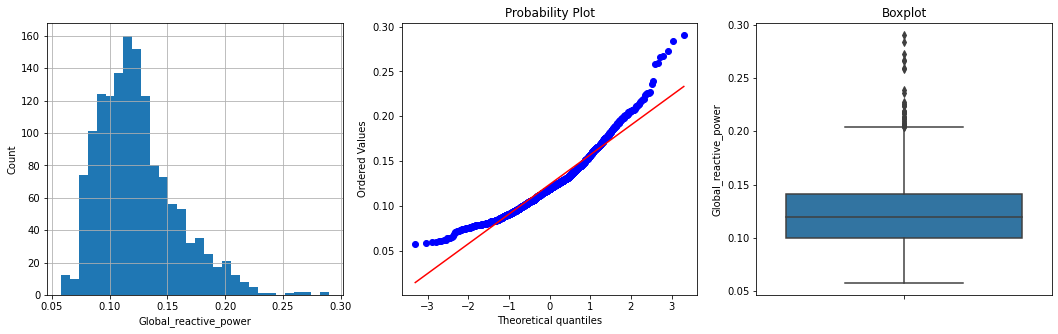

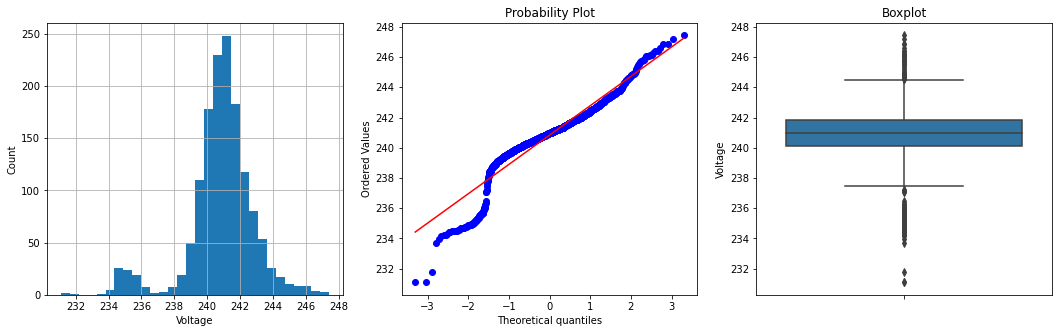

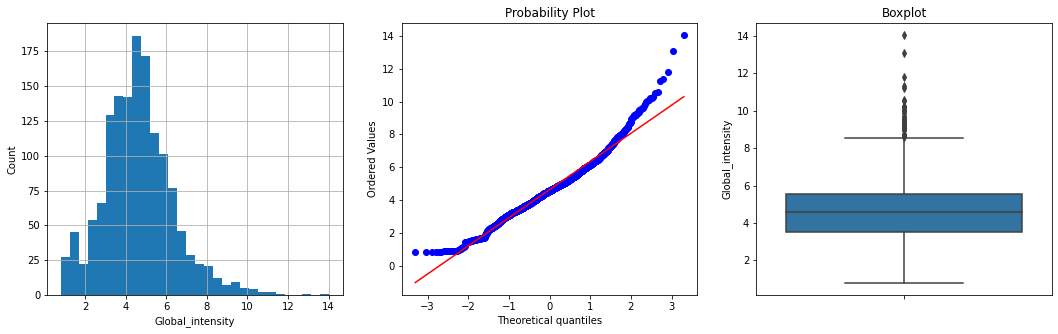

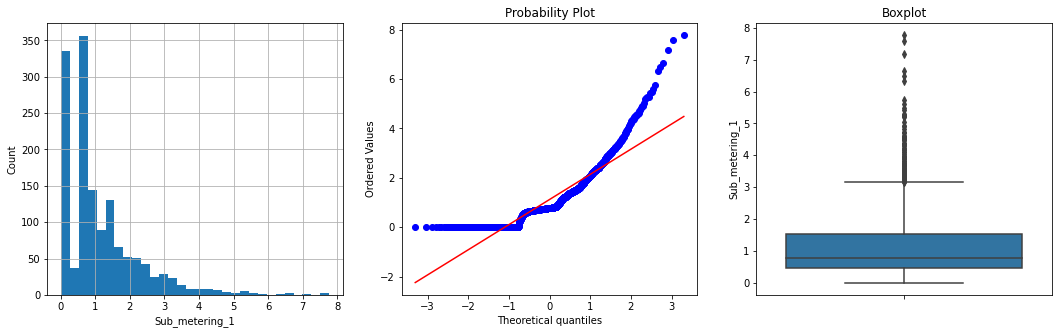

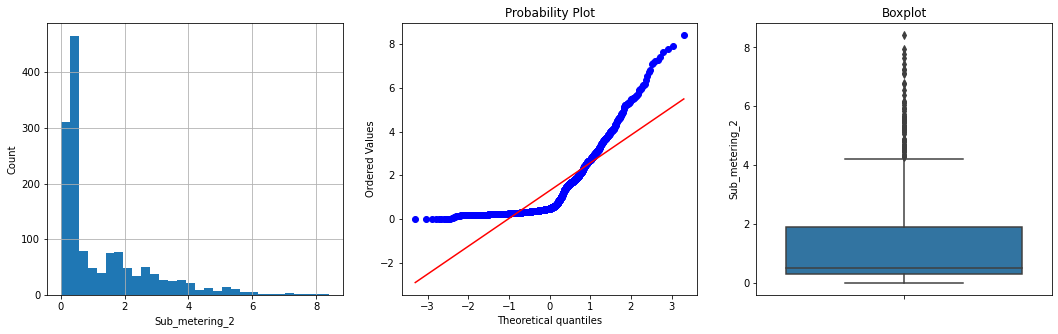

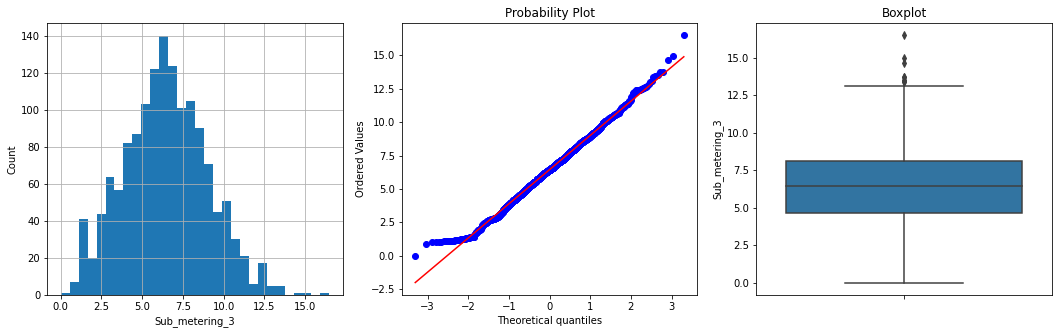

In [52]:
# Define values distribution & define outliers

for var in df:
    diagnostic_plots(df, var)

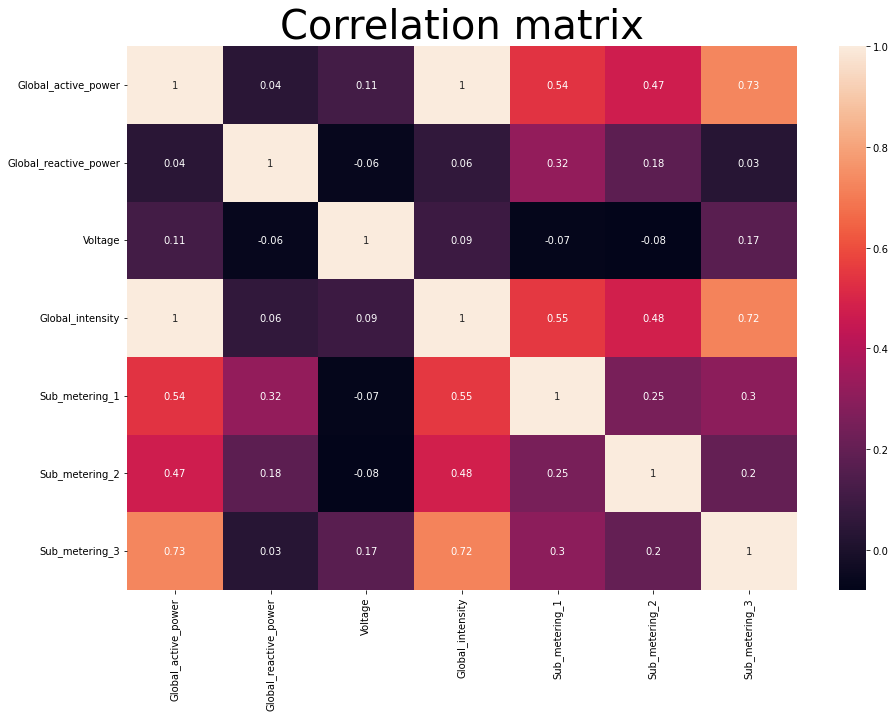

In [53]:
# Check correlation between study variables by using correlation matrix

plt.figure(figsize=(15,10)) 
sns.heatmap(df.corr().round(2),annot=True)
plt.title('Correlation matrix',fontsize = 40)
plt.show()

In [54]:
# Define multicollinearity with treshhold 70%

multicollinearity(df, 0.7)

0.999 Global_intensity Global_active_power
0.729 Sub_metering_3 Global_active_power
0.72 Sub_metering_3 Global_intensity


In [55]:
# Define multicollinearity with treshhold 70%

df = df.drop(['Global_intensity'], axis = 1)

In [56]:
# Scale data values 

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
scaled

array([[0.63681623, 0.29573827, 0.33794529, ..., 0.        , 0.01136636,
        0.78241815],
       [0.54504495, 0.10335773, 0.33550078, ..., 0.        , 0.14465183,
        0.78267595],
       [0.50900588, 0.11007318, 0.28380167, ..., 0.        , 0.03086863,
        0.7741686 ],
       ...,
       [0.2385342 , 0.07752906, 0.41839455, ..., 0.        , 0.00143575,
        0.        ],
       [0.16153105, 0.07899268, 0.52024552, ..., 0.        , 0.022972  ,
        0.        ],
       [0.12594772, 0.        , 0.53152393, ..., 0.        , 0.        ,
        0.        ]])

In [57]:
scaled.shape

(34589, 7)

In [58]:
# reframe columns for timeseries 

reframed = series_to_supervised(scaled)
reframed.drop(reframed.columns[[8, 9, 10, 11, 12, 13]], axis = 1, inplace= True)
reframed.head(10)

var1(t-1  var2(t-1  var3(t-1  var4(t-1  var5(t-1  var6(t-1  var7(t-1  \
1   0.636816  0.295738  0.337945  0.631157       0.0  0.011366  0.782418   
2   0.545045  0.103358  0.335501  0.541487       0.0  0.144652  0.782676   
3   0.509006  0.110073  0.283802  0.502152       0.0  0.030869  0.774169   
4   0.488550  0.096987  0.315987  0.481110       0.0  0.000000  0.778809   
5   0.455597  0.099010  0.434417  0.449904       0.0  0.008973  0.798917   
6   0.322555  0.072536  0.495847  0.323529       0.0  0.002872  0.205723   
7   0.301032  0.092251  0.567188  0.301052       0.0  0.001795  0.000000   
8   0.273201  0.132286  0.580314  0.273434       0.0  0.010050  0.000000   
9   0.501108  0.176840  0.560615  0.492946       0.0  0.543431  0.000000   
10  0.227338  0.101033  0.766632  0.228360       0.0  0.012204  0.000000   

     var1(t)  
1   0.509006  
2   0.488550  
3   0.455597  
4   0.322555  
5   0.301032  
6   0.273201  
7   0.501108  
8   0.227338  
9   0.238980  
10  0.324983

In [59]:
reframed = series_to_supervised(scaled, 5, 3)  #scaled 5 how we go back, 3 how we go forward (this ex one hour)
reframed.drop(reframed.columns[[8, 9, 10, 11, 12, 13]], axis = 1, inplace= True)
reframed.head(10)

var1(t-5  var2(t-5  var3(t-5  var4(t-5  var5(t-5  var6(t-5  var7(t-5  \
5   0.636816  0.295738  0.337945  0.631157       0.0  0.011366  0.782418   
6   0.545045  0.103358  0.335501  0.541487       0.0  0.144652  0.782676   
7   0.509006  0.110073  0.283802  0.502152       0.0  0.030869  0.774169   
8   0.488550  0.096987  0.315987  0.481110       0.0  0.000000  0.778809   
9   0.455597  0.099010  0.434417  0.449904       0.0  0.008973  0.798917   
10  0.322555  0.072536  0.495847  0.323529       0.0  0.002872  0.205723   
11  0.301032  0.092251  0.567188  0.301052       0.0  0.001795  0.000000   
12  0.273201  0.132286  0.580314  0.273434       0.0  0.010050  0.000000   
13  0.501108  0.176840  0.560615  0.492946       0.0  0.543431  0.000000   
14  0.227338  0.101033  0.766632  0.228360       0.0  0.012204  0.000000   

    var1(t-4  var1(t-3  var2(t-3  ...  var5(t+1)  var6(t+1)  var7(t+1)  \
5   0.545045  0.509006  0.110073  ...        0.0   0.001795   0.000000   
6   0.509006  0.488550  0.096987  ...        0.0   0.010050   0.000000   
7   0.488550  0.455597  0.099010  ...        0.0   0.543431   0.000000   
8   0.455597  0.322555  0.072536  ...        0.0   0.012204   0.000000   
9   0.322555  0.301032  0.092251  ...        0.0   0.016511   0.000000   
10  0.301032  0.273201  0.132286  ...        0.0   0.012204   0.412220   
11  0.273201  0.501108  0.176840  ...        0.0   0.003589   0.215777   
12  0.501108  0.227338  0.101033  ...        0.0   0.015434   0.000000   
13  0.227338  0.238980  0.102712  ...        0.0   0.003589   0.000000   
14  0.238980  0.324983  0.120706  ...        0.0   0.016152   0.000000   

    var1(t+2)  var2(t+2)  var3(t+2)  var4(t+2)  var5(t+2)  var6(t+2)  \
5    0.301032   0.092251   0.567188   0.301052        0.0   0.001795   
6    0.273201   0.132286   0.580314   0.273434        0.0   0.010050   
7    0.501108   0.176840   0.560615   0.492946        0.0   0.543431   
8    0.227338   0.101033   0.766632   0.228360        0.0   0.012204   
9    0.238980   0.102712   0.716563   0.240435        0.0   0.016511   
10   0.324983   0.120706   0.691321   0.316714        0.0   0.012204   
11   0.290954   0.077787   0.685745   0.289216        0.0   0.003589   
12   0.183220   0.122471   0.702292   0.180297        0.0   0.015434   
13   0.232428   0.077228   0.614219   0.225968        0.0   0.003589   
14   0.274459   0.153121   0.593728   0.270684        0.0   0.016152   

    var7(t+2)  
5    0.000000  
6    0.000000  
7    0.000000  
8    0.000000  
9    0.000000  
10   0.412220  
11   0.215777  
12   0.000000  
13   0.000000  
14   0.000000  

[10 rows x 50 columns]

In [60]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[8, 9, 10, 11, 12, 13]], axis = 1, inplace= True)
reframed.head(10)

var1(t-1  var2(t-1  var3(t-1  var4(t-1  var5(t-1  var6(t-1  var7(t-1  \
1   0.636816  0.295738  0.337945  0.631157       0.0  0.011366  0.782418   
2   0.545045  0.103358  0.335501  0.541487       0.0  0.144652  0.782676   
3   0.509006  0.110073  0.283802  0.502152       0.0  0.030869  0.774169   
4   0.488550  0.096987  0.315987  0.481110       0.0  0.000000  0.778809   
5   0.455597  0.099010  0.434417  0.449904       0.0  0.008973  0.798917   
6   0.322555  0.072536  0.495847  0.323529       0.0  0.002872  0.205723   
7   0.301032  0.092251  0.567188  0.301052       0.0  0.001795  0.000000   
8   0.273201  0.132286  0.580314  0.273434       0.0  0.010050  0.000000   
9   0.501108  0.176840  0.560615  0.492946       0.0  0.543431  0.000000   
10  0.227338  0.101033  0.766632  0.228360       0.0  0.012204  0.000000   

     var1(t)  
1   0.509006  
2   0.488550  
3   0.455597  
4   0.322555  
5   0.301032  
6   0.273201  
7   0.501108  
8   0.227338  
9   0.238980  
10  0.324983

## Step 5. Splitting Dataset


In [91]:
values = reframed.values

n_train_time = 365 * 24                    # we can use 365*2; 365*3 ..... to cover 2, 3 years period
train = values[:n_train_time, :]
test = values[n_train_time:, :]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3d for Rnn [samples, timesteps, features]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(8760, 1, 7) (8760,) (25391, 1, 7) (25391,)


In [123]:
# Create lists for results of each metrics

model_name = []
rmse_test_scores = []
mae_test_scores = []

In [92]:
# Define callbacks

# Stop training if val_loss don't improve
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)

### 5.1 LSTM Model with 50 neurons

In the first model we defined the LSTM with 50 neurons in the hidden layer without a Dropout Layer. There was an output layer for predicting electricity consumption. For optimizer function we used Adam method. Loss function we used means absolute error. Verbose we put 1 to observe loss and validation loss and shuffle False not to reorganize the dataset and used the data that we have for the consistency in results.

In [64]:
# Building the first LSTM model 

model = Sequential()
model.add(LSTM(50, input_shape = (train_x.shape[1], train_x.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = 'adam')

history1 = model.fit(train_x, 
                    train_y, 
                    epochs = 50, 
                    batch_size = 72, 
                    validation_data=(test_x, test_y), 
                    verbose = 1, 
                    shuffle = False)

Epoch 1/50
122/122 [==============================] - 2s 6ms/step - loss: 0.1132 - val_loss: 0.0899
Epoch 2/50
122/122 [==============================] - 0s 3ms/step - loss: 0.1000 - val_loss: 0.0887
Epoch 3/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0977 - val_loss: 0.0875
Epoch 4/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0963 - val_loss: 0.0869
Epoch 5/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0954 - val_loss: 0.0859
Epoch 6/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0950 - val_loss: 0.0859
Epoch 7/50
122/122 [==============================] - 0s 4ms/step - loss: 0.0946 - val_loss: 0.0857
Epoch 8/50
122/122 [==============================] - 0s 4ms/step - loss: 0.0944 - val_loss: 0.0855
Epoch 9/50
122/122 [==============================] - 0s 4ms/step - loss: 0.0943 - val_loss: 0.0853
Epoch 10/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0942 - val_loss: 0.0851

In [65]:
# Model summary, total 11,651 parameters

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11600     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________


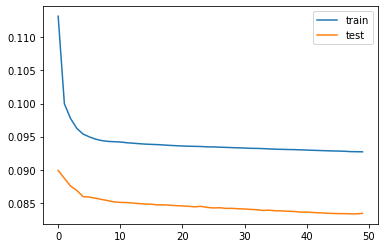

In [66]:
# Controlling loss in train and test sets 

plt.plot(history1.history['loss'], label = 'train')
plt.plot(history1.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [67]:
# calculate RMSE

yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[2]))

# Invert scaling for forecast 
inv_yhat = np.concatenate((yhat, test_x[:, 1:]), axis = 1) 
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# Invert scaling for actual 

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1:]), axis = 1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('RMSE: {:.3f}'.format(rmse))

RMSE: 0.796


In [68]:
# calculate MAE

mae = (mean_absolute_error(inv_y, inv_yhat))
print('Test MAE: %.3f' % mae)

Test MAE: 0.537


In [124]:
# Record the results

model_name.append('LSTM 50 Neurons')

mae_test_scores.append(round(mean_absolute_error(inv_y, inv_yhat),3))
rmse_test_scores.append(round(mean_squared_error(inv_y, inv_yhat),3))

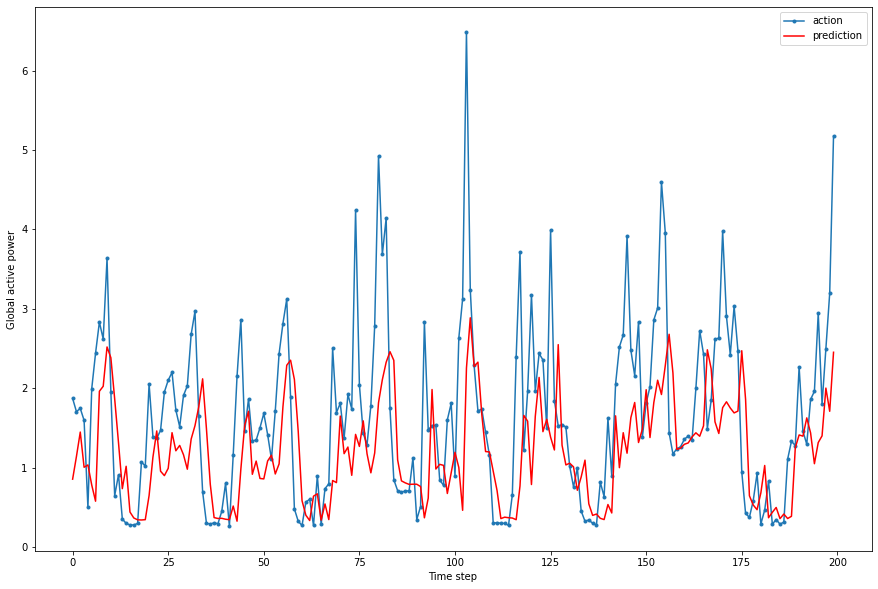

In [70]:
# Making graphs with predicted and actual data 

plt.figure(figsize=(15,10)) 
aa = [x for x in range (200)]
plt.plot(aa, inv_y[:200], marker = '.', label = 'action')
plt.plot(aa, inv_yhat[: 200], 'r', label = 'prediction')
plt.ylabel('Global active power')
plt.xlabel('Time step')
plt.legend()
plt.show()

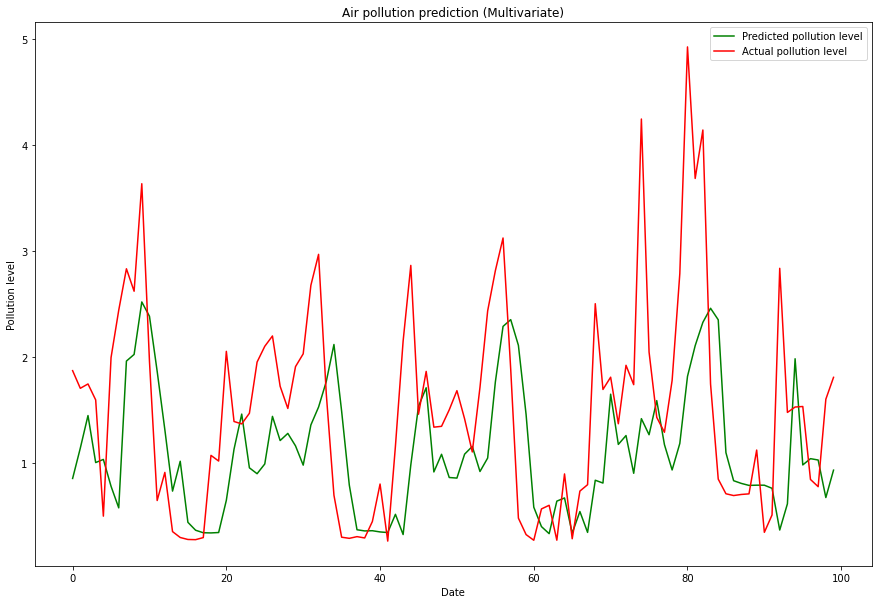

In [71]:
# Making graphs with predicted and actual data 

y_tested = inv_y.reshape(-1, 1)
y_pred = inv_yhat.reshape(-1, 1)

plt.figure(figsize=(15,10)) 
plt.plot(y_pred[:100, :], color = 'green', label = 'Predicted pollution level')
plt.plot(y_tested[:100, :], color = 'red', label = 'Actual pollution level')
plt.title('Air pollution prediction (Multivariate)')
plt.xlabel('Date')
plt.ylabel('Pollution level')
plt.legend()
plt.show()

### 5.2 LSTM Model with 256 neurons

The second model defined the LSTM with 256 neurons in the first hidden layer and a Dropout Layer of 0.25. Next we put a BatchNormalization to normalize the contributions to a layer for every mini-batch and also for regularization and not using another dropout function. Then we put the final output layer for predicting pollution. Optimizer function we used Adam method. Loss function we used means squared error. Loss function we used means absolute error. Verbose we put 1 to observe loss and validation loss and shuffle False not to reorganize the dataset and use the data that we have for the consistency in results. 

In [83]:
# Building the third LSTM model 

model2 = Sequential()
model2.add(LSTM(256, input_shape=(train_x.shape[1], train_x.shape[2])))
model2.add(Dense(64))
model2.add(Dropout(0.25))
model2.add(BatchNormalization())
model2.add(Dense(1))

model2.compile(loss='mse', optimizer='adam')

hist2 = model2.fit(train_x, train_y, epochs=50, batch_size=72, validation_data=(test_x, test_y))

Epoch 1/50
122/122 [==============================] - 3s 10ms/step - loss: 0.0333 - val_loss: 0.0178
Epoch 2/50
122/122 [==============================] - 1s 8ms/step - loss: 0.0234 - val_loss: 0.0171
Epoch 3/50
122/122 [==============================] - 1s 8ms/step - loss: 0.0215 - val_loss: 0.0159
Epoch 4/50
122/122 [==============================] - 1s 7ms/step - loss: 0.0203 - val_loss: 0.0156
Epoch 5/50
122/122 [==============================] - 1s 7ms/step - loss: 0.0194 - val_loss: 0.0148
Epoch 6/50
122/122 [==============================] - 1s 7ms/step - loss: 0.0192 - val_loss: 0.0176
Epoch 7/50
122/122 [==============================] - 1s 7ms/step - loss: 0.0191 - val_loss: 0.0142
Epoch 8/50
122/122 [==============================] - 1s 7ms/step - loss: 0.0184 - val_loss: 0.0139
Epoch 9/50
122/122 [==============================] - 1s 7ms/step - loss: 0.0183 - val_loss: 0.0150
Epoch 10/50
122/122 [==============================] - 1s 7ms/step - loss: 0.0183 - val_loss: 0.013

In [84]:
# Model summary, total 286,977 parameters

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 256)               270336    
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 287,105
Trainable params: 286,977
Non-trainable params: 128
______________________________________________

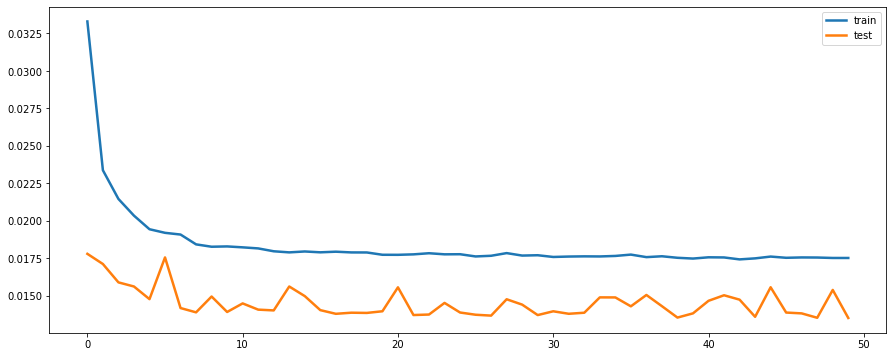

In [85]:
# Controlling loss in train and test sets

plt.figure(figsize=(15,6))
plt.plot(hist2.history['loss'], label='train', linewidth = 2.5)
plt.plot(hist2.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [86]:
# calculate RMSE

yhat_2 = model2.predict(test_x)
test_x_2 = test_x.reshape((test_x.shape[0], test_x.shape[2]))

# Invert scaling for forecast 
inv_yhat_2 = np.concatenate((yhat_2, test_x_2[:, 1:]), axis = 1) 
inv_yhat_2 = scaler.inverse_transform(inv_yhat_2)
inv_yhat_2 = inv_yhat_2[:, 0]

# Invert scaling for actual 

test_y_2 = test_y.reshape((len(test_y), 1))
inv_y_2 = np.concatenate((test_y_2, test_x_2[:, 1:]), axis = 1)
inv_y_2 = scaler.inverse_transform(inv_y_2)
inv_y_2 = inv_y_2[:, 0]

rmse = math.sqrt(mean_squared_error(inv_y_2, inv_yhat_2))
print('RMSE: {:.3f}'.format(rmse))

RMSE: 0.749


In [87]:
# calculate MAE

mae = (mean_absolute_error(inv_y_2, inv_yhat_2))
print('Test MAE: %.3f' % mae)

Test MAE: 0.565


In [125]:
# Record the results

model_name.append('LSTM 250 Neurons')

mae_test_scores.append(round(mean_absolute_error(inv_y_2, inv_yhat_2),3))
rmse_test_scores.append(round(mean_squared_error(inv_y_2, inv_yhat_2),3))

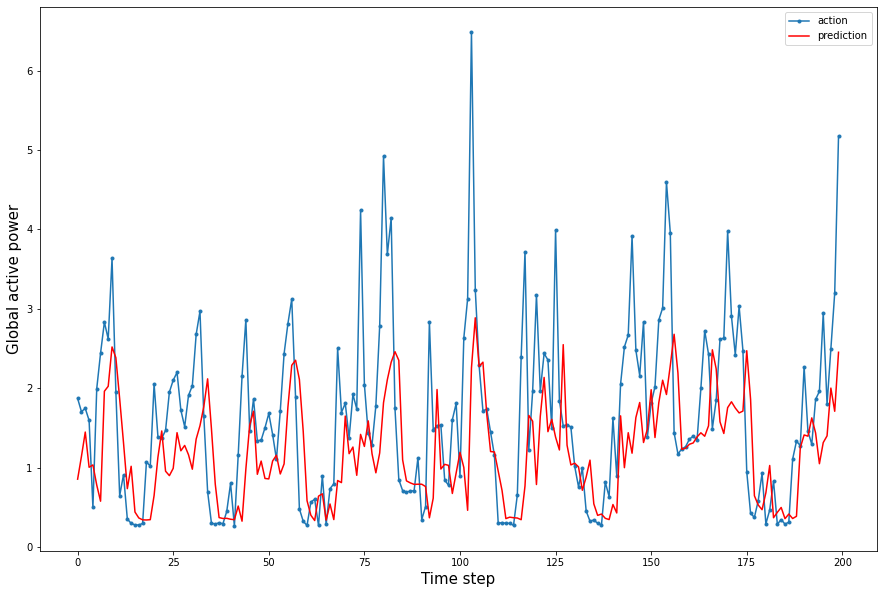

In [89]:
# Making graphs with predicted and actual data 

plt.figure(figsize=(15,10)) 
aa = [x for x in range (200)]
plt.plot(aa, inv_y[:200], marker = '.', label = 'action')
plt.plot(aa, inv_yhat[: 200], 'r', label = 'prediction')
plt.ylabel('Global active power', size = 15)
plt.xlabel('Time step', size = 15)
plt.legend()
plt.show()

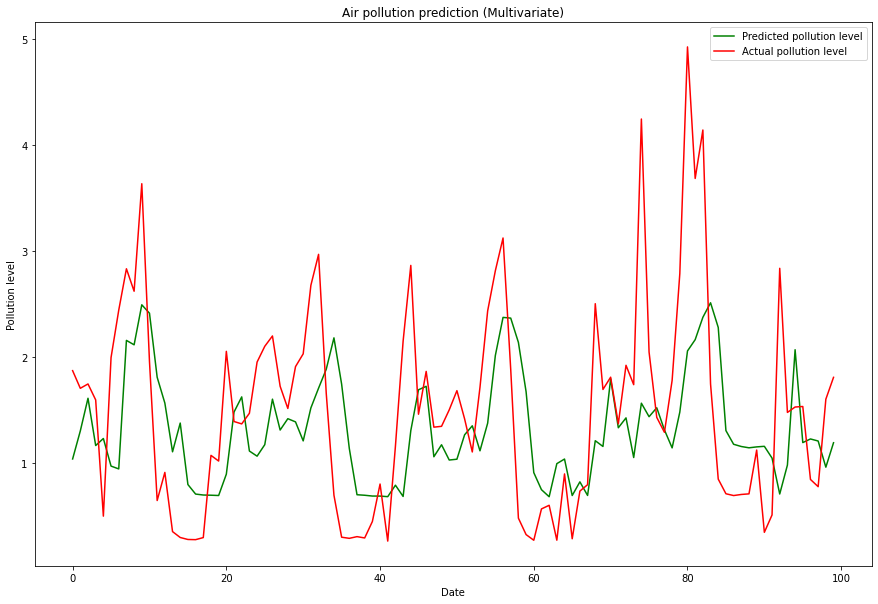

In [90]:
# Making graphs with predicted and actual data 

y_tested_2 = inv_y_2.reshape(-1, 1)
y_pred_2 = inv_yhat_2.reshape(-1, 1)

plt.figure(figsize=(15,10)) 
plt.plot(y_pred_2[:100, :], color = 'green', label = 'Predicted pollution level')
plt.plot(y_tested_2[:100, :], color = 'red', label = 'Actual pollution level')
plt.title('Air pollution prediction (Multivariate)')
plt.xlabel('Date')
plt.ylabel('Pollution level')
plt.legend()
plt.show()

### 5.1 LSTM Model with 512 neurons

In model 4 we defined the LSTM with 512 neurons in the first hidden layer and a Dropout Layer of 0.2. Next we added 2 BatchNormalization to normalize the contributions to a layer for every mini-batch and also for regularization. Then we put the final output layer for predicting pollution. We also used dense layers for changing the dimension of the vectors by using every neuron. Similarly, we have one output layer for predicting electric consumption. Optimizer function we used Adam method. Loss function we used means squared error. Loss function we used means absolute error. Verbose we put 1 to observe loss and validation loss and shuffle False not to reorganize the dataset and use the data that we have for the consistency in results.    

In [93]:
# Building the fourth LSTM model 

model3 = Sequential()
model3.add(LSTM(512, input_shape=(train_x.shape[1], train_x.shape[2])))
model3.add(Dense(75))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())
model3.add(Dense(10))
model3.add(Dropout(0.1))
model3.add(BatchNormalization())
model3.add(Dense(1))
model3.compile(loss='mse', optimizer='adam')

In [94]:
history3 = model3.fit(train_x, train_y, epochs=50, batch_size=240, validation_split=0.2, verbose=2, shuffle=True)

Epoch 1/50
30/30 - 2s - loss: 0.9416 - val_loss: 0.0267 - 2s/epoch - 83ms/step
Epoch 2/50
30/30 - 1s - loss: 0.3683 - val_loss: 0.0275 - 518ms/epoch - 17ms/step
Epoch 3/50
30/30 - 1s - loss: 0.3287 - val_loss: 0.0290 - 510ms/epoch - 17ms/step
Epoch 4/50
30/30 - 1s - loss: 0.2930 - val_loss: 0.0282 - 538ms/epoch - 18ms/step
Epoch 5/50
30/30 - 1s - loss: 0.2809 - val_loss: 0.0290 - 561ms/epoch - 19ms/step
Epoch 6/50
30/30 - 1s - loss: 0.2648 - val_loss: 0.0273 - 634ms/epoch - 21ms/step
Epoch 7/50
30/30 - 1s - loss: 0.2524 - val_loss: 0.0261 - 698ms/epoch - 23ms/step
Epoch 8/50
30/30 - 1s - loss: 0.2335 - val_loss: 0.0260 - 681ms/epoch - 23ms/step
Epoch 9/50
30/30 - 1s - loss: 0.2167 - val_loss: 0.0254 - 586ms/epoch - 20ms/step
Epoch 10/50
30/30 - 1s - loss: 0.1984 - val_loss: 0.0263 - 573ms/epoch - 19ms/step
Epoch 11/50
30/30 - 1s - loss: 0.1896 - val_loss: 0.0248 - 537ms/epoch - 18ms/step
Epoch 12/50
30/30 - 1s - loss: 0.1843 - val_loss: 0.0253 - 528ms/epoch - 18ms/step
Epoch 13/50
30/3

In [95]:
# Model summary, total 1,104,376 parameters

model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 512)               1064960   
                                                                 
 dense_8 (Dense)             (None, 75)                38475     
                                                                 
 dropout_4 (Dropout)         (None, 75)                0         
                                                                 
 batch_normalization_3 (Batc  (None, 75)               300       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 10)                760       
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                      

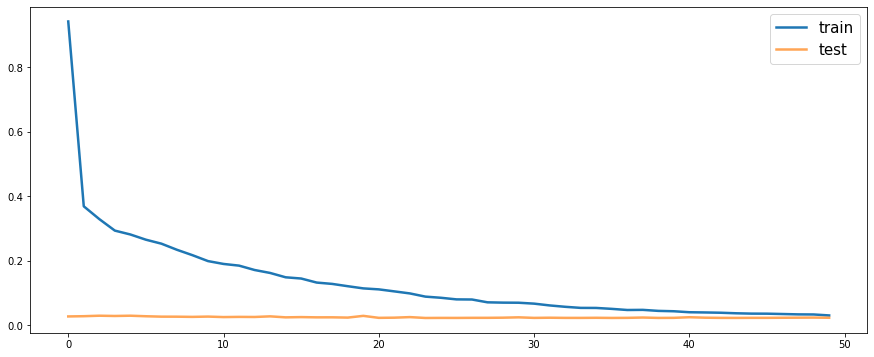

In [96]:
# Controlling loss in train and test sets

plt.figure(figsize=(15,6))
plt.plot(history3.history['loss'], label='train', linewidth = 2.5)
plt.plot(history3.history['val_loss'], label='test', alpha=.7, linewidth = 2.5)
plt.legend(fontsize=15)
plt.show()

In [97]:
# calculate RMSE

yhat_3 = model3.predict(test_x)
test_x_3 = test_x.reshape((test_x.shape[0], test_x.shape[2]))

# Invert scaling for forecast 
inv_yhat_3 = np.concatenate((yhat_3, test_x_3[:, 1:]), axis = 1) 
inv_yhat_3 = scaler.inverse_transform(inv_yhat_3)
inv_yhat_3 = inv_yhat_3[:, 0]

# Invert scaling for actual 

test_y_3 = test_y.reshape((len(test_y), 1))
inv_y_3 = np.concatenate((test_y_3, test_x_3[:, 1:]), axis = 1)
inv_y_3 = scaler.inverse_transform(inv_y_3)
inv_y_3 = inv_y_3[:, 0]

rmse = math.sqrt(mean_squared_error(inv_y_3, inv_yhat_3))
print('RMSE: {:.3f}'.format(rmse))

RMSE: 0.759


In [98]:
# calculate MAE

mae = (mean_absolute_error(inv_y_3, inv_yhat_3))
print('Test MAE: %.3f' % mae)

Test MAE: 0.576


In [126]:
model_name.append('LSTM 512 Neurons')

mae_test_scores.append(round(mean_absolute_error(inv_y_3, inv_yhat_3),3))
rmse_test_scores.append(round(mean_squared_error(inv_y_3, inv_yhat_3),3))

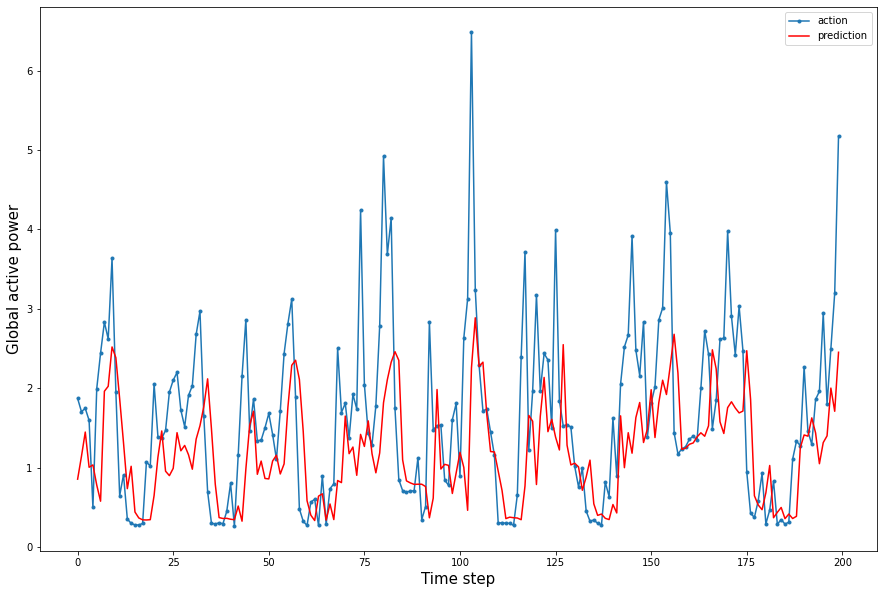

In [100]:
# Making graphs with predicted and actual data 

plt.figure(figsize=(15,10)) 
aa = [x for x in range (200)]
plt.plot(aa, inv_y[:200], marker = '.', label = 'action')
plt.plot(aa, inv_yhat[: 200], 'r', label = 'prediction')
plt.ylabel('Global active power', size = 15)
plt.xlabel('Time step', size = 15)
plt.legend()
plt.show()

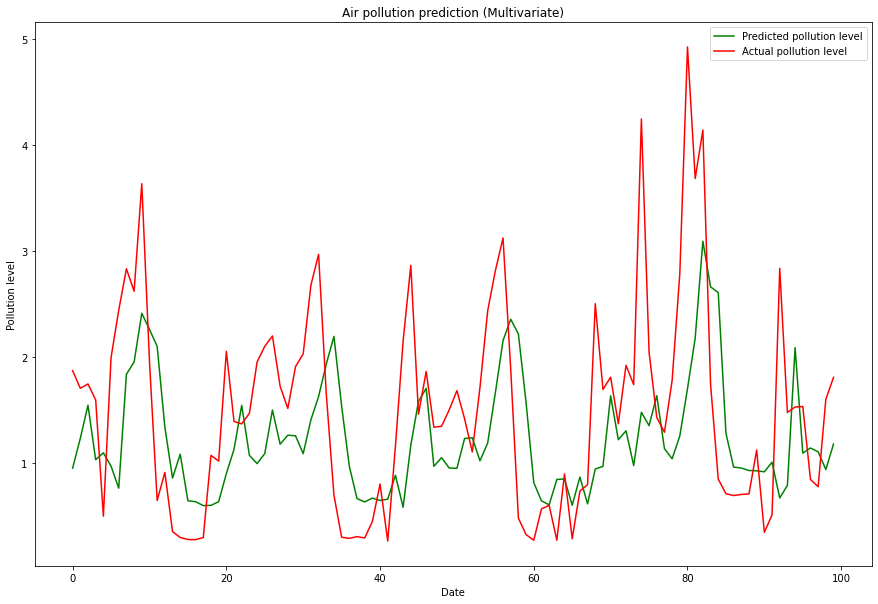

In [101]:
# Making graphs with predicted and actual data 

y_tested_3 = inv_y_3.reshape(-1, 1)
y_pred_3 = inv_yhat_3.reshape(-1, 1)

plt.figure(figsize=(15,10)) 
plt.plot(y_pred_3[:100, :], color = 'green', label = 'Predicted pollution level')
plt.plot(y_tested_3[:100, :], color = 'red', label = 'Actual pollution level')
plt.title('Air pollution prediction (Multivariate)')
plt.xlabel('Date')
plt.ylabel('Pollution level')
plt.legend()
plt.show()

### 5.1 LSTM Model with several LSTM layers

In model 5 we defined the LSTM with 100 neurons in the first hidden layer and a Dropout Layer of 0.3,Next there was another hidden layer of 50 neurons and a Dropout of 0.2. Similarly, there was two more hidden layers with respective 0.2 Dropouts and 50 neurons. In the Final Layer, 1 neuron in the output layer for predicting electricity consumption. In the activation Function we used a linear function, because of the sequential dataset. Optimizer function we used Adam method. Loss function we used means squared error. By monitoring the value of the test data loss function, stop the training model when it is not decreasing, and save the current best model.

In [102]:
# Building the fifth LSTM model

model4 = Sequential()
model4.add(LSTM(100, return_sequences = True, input_shape=(train_x.shape[1], train_x.shape[2])))
model4.add(Dropout(0.3))

model4.add(LSTM(units = 50, return_sequences = True))
model4.add(Dropout(0.2))

model4.add(LSTM(units = 50, return_sequences = True))
model4.add(Dropout(0.2))

model4.add(LSTM(units = 50))
model4.add(Dropout(0.2))

model4.add(Dense(1,activation='linear'))

model4.compile(loss='mse', optimizer='adam')

In [103]:
history4 = model4.fit(train_x, train_y, epochs=50, batch_size=72, validation_data=(test_x, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 7s - loss: 0.0288 - val_loss: 0.0215 - 7s/epoch - 55ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0194 - val_loss: 0.0167 - 866ms/epoch - 7ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0186 - val_loss: 0.0162 - 863ms/epoch - 7ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0180 - val_loss: 0.0163 - 874ms/epoch - 7ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0178 - val_loss: 0.0165 - 866ms/epoch - 7ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0177 - val_loss: 0.0165 - 863ms/epoch - 7ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0176 - val_loss: 0.0163 - 879ms/epoch - 7ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0175 - val_loss: 0.0165 - 918ms/epoch - 8ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0176 - val_loss: 0.0164 - 932ms/epoch - 8ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0176 - val_loss: 0.0161 - 901ms/epoch - 7ms/step
Epoch 11/50
122/122 - 1s - loss: 0.0175 - val_loss: 0.0163 - 879ms/epoch - 7ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0175 - val_loss: 0.0161 - 867ms/epoch - 7ms/step
Epo

In [104]:
# Model summary, total 113,851 parameters

model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 100)            43200     
                                                                 
 dropout_6 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_7 (LSTM)               (None, 1, 50)             30200     
                                                                 
 dropout_7 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_8 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_9 (LSTM)               (None, 50)               

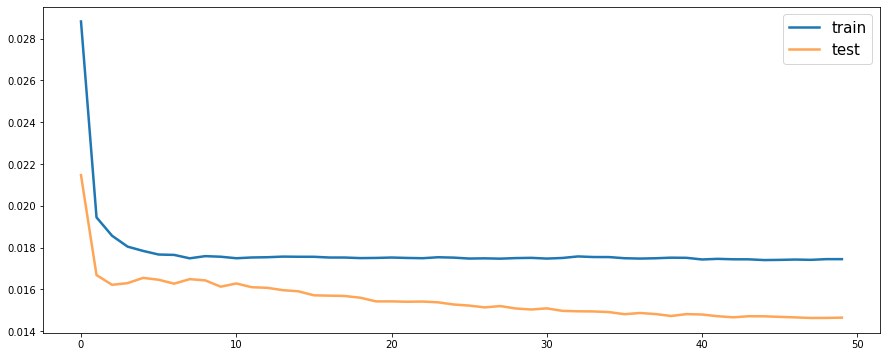

In [105]:
# Controlling loss in train and test sets

plt.figure(figsize=(15,6))
plt.plot(history4.history['loss'], label='train', linewidth = 2.5)
plt.plot(history4.history['val_loss'], label='test', alpha=.7, linewidth = 2.5)
plt.legend(fontsize=15)
plt.show()

In [106]:
# calculate RMSE

yhat_4 = model4.predict(test_x)
test_x_4 = test_x.reshape((test_x.shape[0], test_x.shape[2]))

# Invert scaling for forecast 
inv_yhat_4 = np.concatenate((yhat_4, test_x_4[:, 1:]), axis = 1) 
inv_yhat_4 = scaler.inverse_transform(inv_yhat_4)
inv_yhat_4 = inv_yhat_4[:, 0]

# Invert scaling for actual 

test_y_4 = test_y.reshape((len(test_y), 1))
inv_y_4 = np.concatenate((test_y_4, test_x_4[:, 1:]), axis = 1)
inv_y_4 = scaler.inverse_transform(inv_y_4)
inv_y_4 = inv_y_4[:, 0]

rmse = math.sqrt(mean_squared_error(inv_y_4, inv_yhat_4))
print('RMSE: {:.3f}'.format(rmse))

RMSE: 0.779


In [107]:
# calculate MAE

mae = (mean_absolute_error(inv_y_4, inv_yhat_4))
print('Test MAE: %.3f' % mae)

Test MAE: 0.640


In [127]:
model_name.append('Several LSTM Neurons')

mae_test_scores.append(round(mean_absolute_error(inv_y_4, inv_yhat_4),3))
rmse_test_scores.append(round(mean_squared_error(inv_y_4, inv_yhat_4),3))

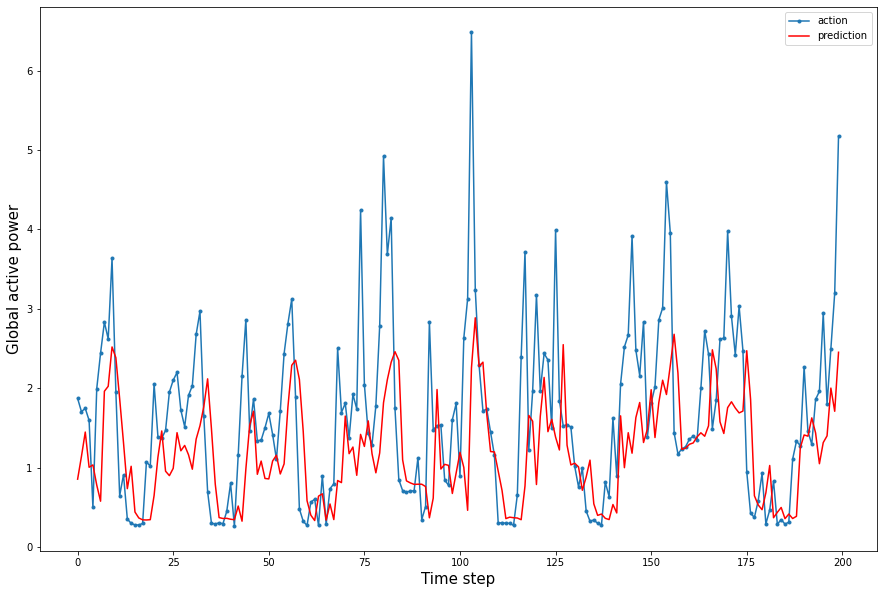

In [109]:
# Making graphs with predicted and actual data 

plt.figure(figsize=(15,10)) 
aa = [x for x in range (200)]
plt.plot(aa, inv_y[:200], marker = '.', label = 'action')
plt.plot(aa, inv_yhat[: 200], 'r', label = 'prediction')
plt.ylabel('Global active power', size = 15)
plt.xlabel('Time step', size = 15)
plt.legend()
plt.show()

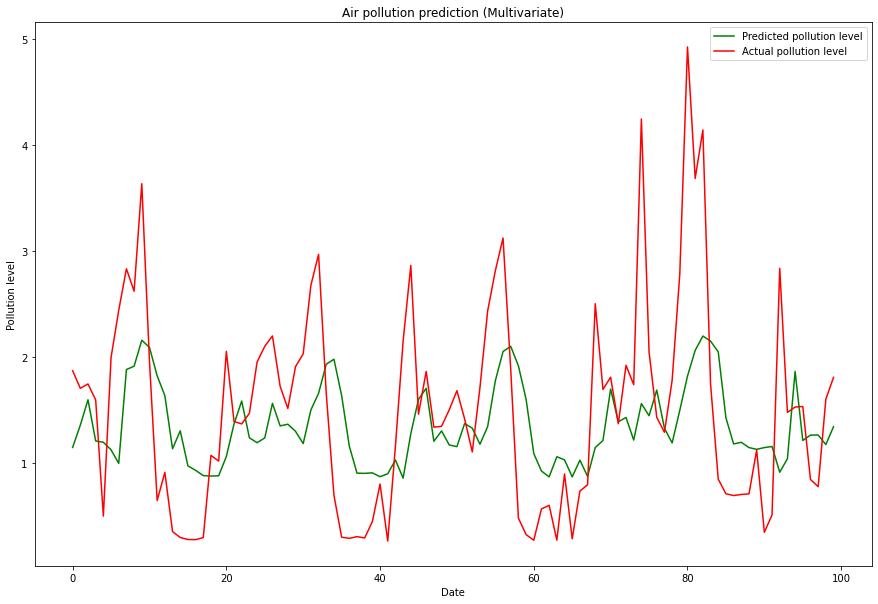

In [110]:
# Making graphs with predicted and actual data 

y_tested_4 = inv_y_4.reshape(-1, 1)
y_pred_4 = inv_yhat_4.reshape(-1, 1)

plt.figure(figsize=(15,10)) 
plt.plot(y_pred_4[:100, :], color = 'green', label = 'Predicted pollution level')
plt.plot(y_tested_4[:100, :], color = 'red', label = 'Actual pollution level')
plt.title('Air pollution prediction (Multivariate)')
plt.xlabel('Date')
plt.ylabel('Pollution level')
plt.legend()
plt.show()

In [135]:
# Create DataFrame with models' scores

model_results = pd.DataFrame({'model_name': model_name, 
                             'mae_test_scores': mae_test_scores, 
                             'rmse_test_scores': rmse_test_scores,
                             })

model_results.sort_values(by = 'mae_test_scores', ascending = False)

model_name  mae_test_scores  rmse_test_scores
3  Several LSTM Neurons            0.640             0.607
2      LSTM 512 Neurons            0.576             0.576
1      LSTM 250 Neurons            0.565             0.560
0       LSTM 50 Neurons            0.537             0.633

## Step 6. Conclusion


The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years. The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute. 

I found that all 7 variables have the same percentage of NaN values which is about 1.3% or 25.979 observations of the whole dataset. Finding that there are null values in the dataset I suggested that there were once planned or unscheduled power outages, and therefore, the sensors could not record the consumption of electricity. Though all variables contain missing values, this number is relatively small (less than 1%). Therefore, I filled the null values with the median value of electricity consumption rate per day without dramatic changes in the distribution (original and imputed).  

In the basic LSTM model with 50 neurons in the hidden layer without a Dropout Layer and one output layer for predicting electricity consumption showed the minimal amount of the error (Test MAE: 0.537). The model 2 with 256 neurons in the first hidden layer and a Dropout Layer of 0.25 showed the minimal amount of the error too (RMSE: 0.560).
